# Package importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from tqdm import tqdm, trange
from copy import deepcopy

from statsmodels.api import OLS
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import functional as F
device = torch.device('cuda:0')
torch.set_default_device(device.type+':'+str(device.index))

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import  Simpson# The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

from functorch import  jacfwd, hessian as ft_hessian

set_up_backend("torch", data_type="float32")

simp = Simpson()

def integral( f, a, b):
    return simp.integrate(f, dim=1, N=101, integration_domain=[[a, b]])

import gc


/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
import pickle
def open_pickle(name):
    with open('./'+name+'.pickle', 'rb') as f:
         return pickle.load(f)

def save_pickle(name,data):
    with open('./'+name+'.pickle', 'wb') as f:
        pickle.dump(data, f)

We define manually the number of parameters and their names as per the CVA experiment in the paper.

In [3]:
risk_horizons =[0.01, 0.1, 1]

num_para = 103
num_diff = 28
num_rates = 10
num_spreads = 9
num_paths = 2**17
num_defs_per_path = 1



group = dict()
group[0] = np.arange(num_rates) # initial interest rate
group[1] = np.arange(num_rates, 2*num_rates-1) # initial fx rate
group[2] = np.arange(2*num_rates, 2*num_rates + num_spreads- 1) # initial spread rate
group[3] = np.arange(num_diff, num_diff + num_rates) # speed parameters for interest rate
group[4] = np.arange(num_diff+ num_rates, num_diff + 2*num_rates) # longterm mean  for interest rate
group[5] = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates) # vol for interest rate
group[6] = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)  # vol for fx rate
group[7] = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)  # speed parameters for spread rate 
group[8] = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1) # longterm mean  for spread rate
group[9] = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1) # vol for spread rate
name_group = dict()
name_group[0] = ['ini rate']*len(group[0])
name_group[1] = ['ini fx']*len(group[1])
name_group[2] = ['ini spread']*len(group[2])
name_group[3] = ['speed rate']*len(group[3])
name_group[4] = ['longmean rate']*len(group[4])
name_group[5] = ['vol rate']*len(group[5])
name_group[6] = ['vol fx']*len(group[6])
name_group[7] = ['speed spread']*len(group[7])
name_group[8] = ['longmean spread']*len(group[8])
name_group[9] = ['vol spread']*len(group[9])

index_para = np.concatenate(list(group.values())) #np.arange(d['features'].shape[1])#~np.in1d(np.arange(19), [3,12,13,15,17])
index_para_name = np.concatenate(list(name_group.values())) #np.arange(d['features'].shape[1])#~np.in1d(np.arange(19), [3,12,13,15,17])


# Importing benchmark and smart bump sensitivities, and linear sensitivities

In [4]:
with open('10_9_0.pickle', 'rb') as file:
    data_sensis = pickle.load(file)

In [5]:
sensis_para_linear = data_sensis[1]['delta'][index_para]
sensis_para_smart = data_sensis[2]['delta'][index_para]
sensis_para_benchmark = data_sensis[3]['delta'][index_para]
sensis_para_gamma_benchmark = data_sensis[3]['gamma'][index_para]

tab_sensi = pd.DataFrame([index_para, index_para_name, sensis_para_linear, sensis_para_smart, sensis_para_benchmark],
                         index=('idx', 'idx_name', 'linear','smart','benchmark')).T

tab_sensi.head()

,idx,idx_name,linear,smart,benchmark
0,0,ini rate,-13484.192643,-12602.763672,-12275.573242
1,1,ini rate,-4944.909141,-4947.615234,-4713.888672
2,2,ini rate,11835.854731,11204.243164,10728.65918
3,3,ini rate,1428.077893,1438.040039,1449.329956
4,4,ini rate,14035.238439,14941.932617,14708.267578


d = open_pickle('sensis')

d.keys()
tab_sensi['linear']  = d['sensis_linear'][index_para]
tab_sensi['smart']  = d['sensis_fast'][index_para]

d = open_pickle('prod_mixture_sensi')
tab_sensi['benchmark'] = d['deltaCVA'].ravel()[index_para]

In [6]:
data_shocked_paths = open_pickle('data_for_run-off_analysis')

features_baseline0 = data_shocked_paths['features_baseline0']
features_train = data_shocked_paths['features_risk_train']
features_test = data_shocked_paths['features_risk_test']

LGD_train = data_shocked_paths['LGD_risk_train']
LGD_test = data_shocked_paths['LGD_risk_test']

instant_def_ind_train = data_shocked_paths['instant_def_ind_risk_train']
instant_def_ind_test = data_shocked_paths['instant_def_ind_risk_test']

dc_factor_train = data_shocked_paths['dc_factor_risk_train']
dc_factor_test = data_shocked_paths['dc_factor_risk_test']

xi_train = data_shocked_paths['xi_risk_train']
xi_test = data_shocked_paths['xi_risk_test']

CVA_nn_train = data_shocked_paths['CVA_nn_train']
CVA_nn_test = data_shocked_paths['CVA_nn_test']


CVA_nested_test = data_shocked_paths['nested_risk']

twin_y12 = data_shocked_paths['twin_y12_risk']

CVA_0 = data_shocked_paths['CVA_0']

del data_shocked_paths
gc.collect()

0

In [7]:
features_origial = np.concatenate([features_baseline0[0, 0:27], features_baseline0[0,26:27],
                                 features_baseline0[0, 27:num_para-1]
                                  ])

index_para_crop = index_para.copy()
index_para_crop[index_para_crop>19]-=1
features_baseline0 = features_baseline0[:, index_para_crop]
features_train = [d[:, :, index_para_crop] for d in  features_train]
features_test = [d[:, :, index_para_crop] for d in  features_test]

# Computing market sensitivities via implicit function theorem

To this end, we define a pseudo calibration loss function as below. The parameters for interest rate models and fx models need to be jointly calibarated, which are independent with  the paramters for default intensity models.

## Sensitivities to ZCs and FX forwards

In [8]:
from functorch import jacfwd, hessian as ft_hessian
zc_mat = torch.tensor([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float64)
fx_mat = torch.tensor([0.01, 0.1, 0.2, 0.5], dtype = torch.float64)
def B_tT(a, t, T):
    return 1/a*(1-torch.exp(-a*(T-t)))
def A_tT(a,b,sigma,t,T):
    return torch.exp((b-sigma**2/(2*a**2))*(B_tT(a,t,T)-T+t)-sigma**2/(4*a)*B_tT(a,t,T)**2)

def pricer_ZC_tT(rt, a, b, sigma, t, T):
    return A_tT(a,b,sigma,t, torch.maximum(T,torch.tensor(t).to(T)) )*torch.exp(-B_tT(a, t, torch.maximum(T,torch.tensor(t).to(T)))*rt)

def pricer_Yield_tT(rt, a, b, sigma, t, T):
    return -torch.log(pricer_ZC_tT(rt, a, b, sigma, t, T)) / T

def loss_calib_zc_ref(market_zc, phi_rate, sig_rate):
    loss = 0.
    for mzc, mat in zip(market_zc, zc_mat):
        loss += (pricer_ZC_tT(phi_rate[0], phi_rate[1], phi_rate[2], sig_rate, 0, mat) - mzc)**2
    return loss

def jab_matrix_zc_ref(ini_rate, a_rate, b_rate, sig_rate):
    phi_rate = torch.tensor([ini_rate, a_rate, b_rate, ], dtype = torch.float64)
    market_zc = torch.tensor([pricer_ZC_tT(ini_rate,a_rate,b_rate,sig_rate, 0, t) for t in zc_mat], dtype = torch.float64)
    
    hess_phi = ft_hessian(loss_calib_zc_ref, argnums=1)(market_zc, phi_rate, sig_rate).to(dtype = torch.float64)
    jac_phi_pi = jacfwd(jacfwd(loss_calib_zc_ref, argnums=0), argnums=1)(market_zc, phi_rate, sig_rate ).to(dtype = torch.float64)                                        
    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T

def loss_calib_zc_fx(market_zc_fx, phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike):
    loss = 0.
    for mzc, mfx, mstrike_fx, mat in zip(market_zc_fx[0:len(zc_mat)], market_zc_fx[len(zc_mat):],market_fx_strike, zc_mat):
        zc_fo = pricer_ZC_tT(phi[0], phi[1], phi[2], sig_rate,0,mat)
        zc_ref = pricer_ZC_tT(phi_ref[0], phi_ref[1],  phi_ref[2], sig_rate_ref,0,mat)
        loss += (phi[3]*zc_fo - mzc)**2  
        
        # We use only short term fx forward contrats to calibrate fx model parameters
        if mat < 1.:
            loss += ( zc_ref*(phi[3]*zc_fo/zc_ref- mstrike_fx) - mfx)**2

    return loss


def jab_matrix_zc_fx(ini_rate, a_rate, b_rate, sig_rate, fx0, ini_rate_ref, a_rate_ref, b_rate_ref, sig_rate_ref):
    phi = torch.tensor([ini_rate, a_rate, b_rate, fx0], dtype = torch.float64)
    phi_ref = torch.tensor([ini_rate_ref, a_rate_ref, b_rate_ref], dtype = torch.float64)

    market_zc = torch.tensor([pricer_ZC_tT(ini_rate, a_rate, b_rate, sig_rate, 0, t) for t in zc_mat], dtype = torch.float64)
    market_zc_ref = torch.tensor([pricer_ZC_tT(ini_rate_ref, a_rate_ref, b_rate_ref, sig_rate_ref, 0, t) for t in zc_mat], dtype = torch.float64)

    market_fx_strike = market_zc/market_zc_ref*fx0

    market_fx = (market_zc/market_zc_ref*fx0 - market_fx_strike)*market_zc_ref # at the money fx forward
    market_zc_fx = torch.cat([market_zc*fx0, market_fx ]) # all products are priced in the reference currency 

    hess_phi = ft_hessian(loss_calib_zc_fx, argnums=1)(market_zc_fx, phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike ).to(dtype = torch.float64)
    jac_phi_pi = jacfwd(jacfwd(loss_calib_zc_fx, argnums=0), argnums=1)(market_zc_fx,  phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike ).to(dtype = torch.float64)                                        
    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T

In [9]:
rate_fx_jacobians = []

for i in range(num_rates):
    if i == 0:
        ini_ref = features_origial[group[0]][i]
        a_ref = features_origial[group[3]][i]
        b_ref = features_origial[group[4]][i]
        sig_ref = features_origial[group[5]][i]
        rate_fx_jacobians.append(jab_matrix_zc_ref(ini_ref, a_ref, b_ref, sig_ref))
    else:
        ini = features_origial[group[0]][i]
        a = features_origial[group[3]][i]
        b = features_origial[group[4]][i]
        sig = features_origial[group[5]][i]
        fx0 = features_origial[group[1]][i-1]
        rate_fx_jacobians.append(jab_matrix_zc_fx(ini, a, b, sig, fx0, ini_ref, a_ref, b_ref, sig_ref))

/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('hessian')
/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprec

In [10]:
sensi_ZC_linear = list()
sensi_ZC_benchmark = list()
sensi_ZC_smart = list()

sensi_FX_linear = list()
sensi_FX_benchmark = list()
sensi_FX_smart = list()


ZC_market = list()
FX_market = list()

Yield_market = list()
FX_Yield_market = list()
FX_Forward_market = list()
FX_strike = list()

for edx in range(num_rates):

    ini = torch.tensor(features_origial[group[0]][edx], dtype = torch.float64)
    a = torch.tensor(features_origial[group[3]][edx], dtype = torch.float64)
    b = torch.tensor(features_origial[group[4]][edx], dtype = torch.float64)
    sig = torch.tensor(features_origial[group[5]][edx], dtype = torch.float64)

    zc_m = torch.tensor([pricer_ZC_tT(ini,a,b,sig, 0, t) for t in zc_mat])
    ZC_market.append( zc_m)
    Yield_market.append(-torch.log(zc_m)/zc_mat)
    
    
    
    tab_ini = tab_sensi[tab_sensi['idx'] == group[0][edx]]
    tab_a = tab_sensi[tab_sensi['idx'] == group[3][edx]]
    tab_b = tab_sensi[tab_sensi['idx'] == group[4][edx]]
    
    if edx == 0: 
        sensi_para_rate_linear = np.array([tab_ini['linear'], tab_a['linear'], tab_b['linear']], dtype = np.float32).reshape(1,3)
        sensi_para_rate_benchmark = np.array([tab_ini['benchmark'], tab_a['benchmark'], tab_b['benchmark']], dtype = np.float32).reshape(1,3)
        sensi_para_rate_smart = np.array([ tab_ini['smart'], tab_a['smart'], tab_b['smart']], dtype = np.float32).reshape(1,3)

        sensi_ZC_linear.append(np.matmul(sensi_para_rate_linear, rate_fx_jacobians[edx]).ravel())
        sensi_ZC_benchmark.append(np.matmul(sensi_para_rate_benchmark, rate_fx_jacobians[edx]).ravel())
        sensi_ZC_smart.append(np.matmul(sensi_para_rate_smart, rate_fx_jacobians[edx]).ravel())
    else:
        fx0 = features_origial[group[1]][edx-1]
        
        FX_Yield_market.append((-torch.log(fx0*zc_m/ZC_market[0])/zc_mat)[0:4])
        FX_Forward_market.append((fx0*zc_m/ZC_market[0])[0:4])
        FX_strike.append(fx0*zc_m/ZC_market[0])
        
        tab_fx = tab_sensi[tab_sensi['idx'] == group[1][edx-1]]
        
        sensi_para_rate_fx_linear = np.array([tab_ini['linear'], tab_a['linear'], tab_b['linear'], tab_fx['linear']], dtype = np.float32).reshape(1,4)
        sensi_para_rate_fx_benchmark = np.array([tab_ini['benchmark'], tab_a['benchmark'], tab_b['benchmark'], tab_fx['benchmark']], dtype = np.float32).reshape(1,4)
        sensi_para_rate_fx_smart = np.array([tab_ini['smart'], tab_a['smart'], tab_b['smart'], tab_fx['smart']], dtype = np.float32).reshape(1,4)

        out_linear = np.matmul(sensi_para_rate_fx_linear, rate_fx_jacobians[edx]).ravel()
        out_benchmark = np.matmul(sensi_para_rate_fx_benchmark, rate_fx_jacobians[edx]).ravel()
        out_smart = np.matmul(sensi_para_rate_fx_smart, rate_fx_jacobians[edx]).ravel()
        
        sensi_ZC_linear.append(out_linear[0:len(zc_mat)])
        sensi_FX_linear.append(out_linear[len(zc_mat): len(zc_mat)+4])
        
        sensi_ZC_benchmark.append(out_benchmark[0:len(zc_mat)])
        sensi_FX_benchmark.append(out_benchmark[len(zc_mat): len(zc_mat)+4])
        
        sensi_ZC_smart.append(out_smart[0:len(zc_mat)])
        sensi_FX_smart.append(out_smart[len(zc_mat): len(zc_mat)+4])
FX_strike = torch.cat([fx.reshape(1,-1) for fx in FX_strike])

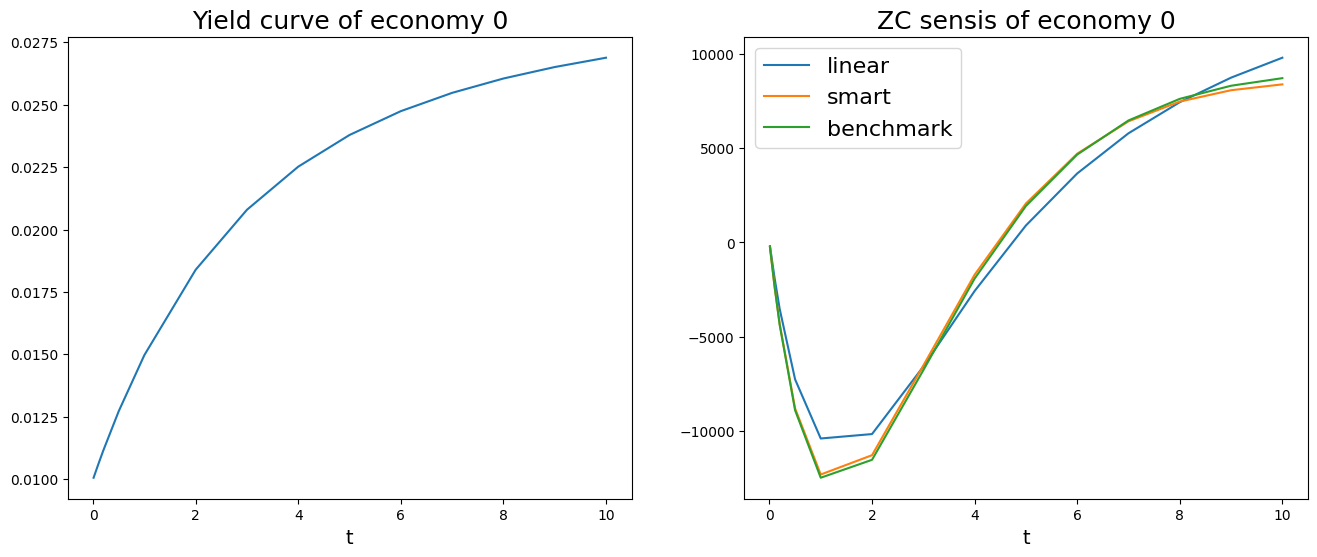

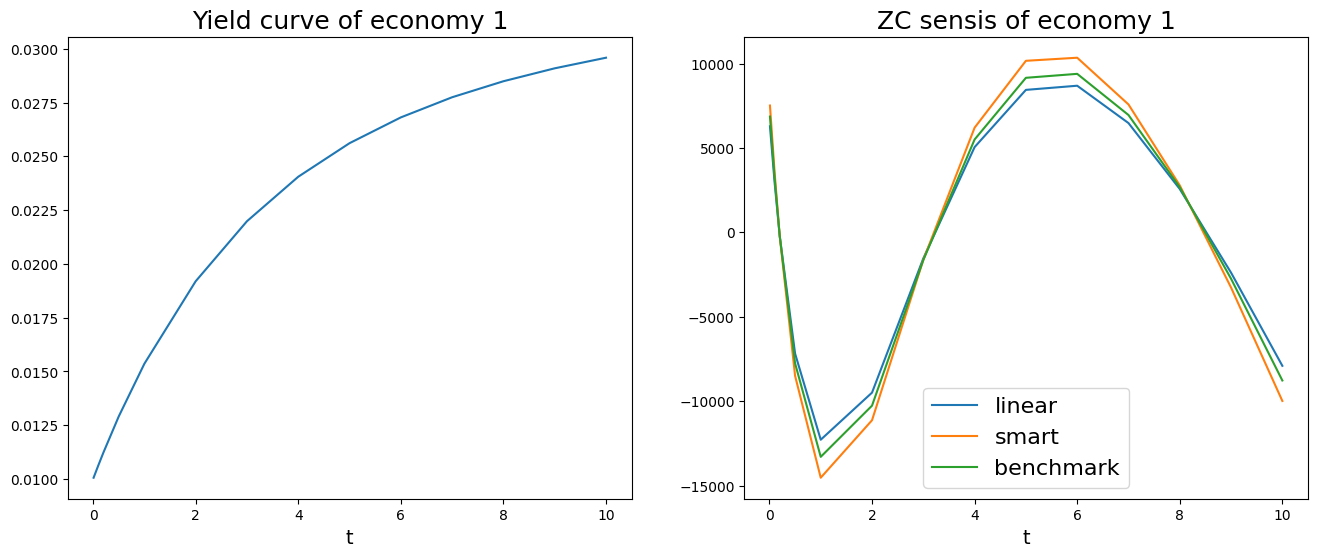

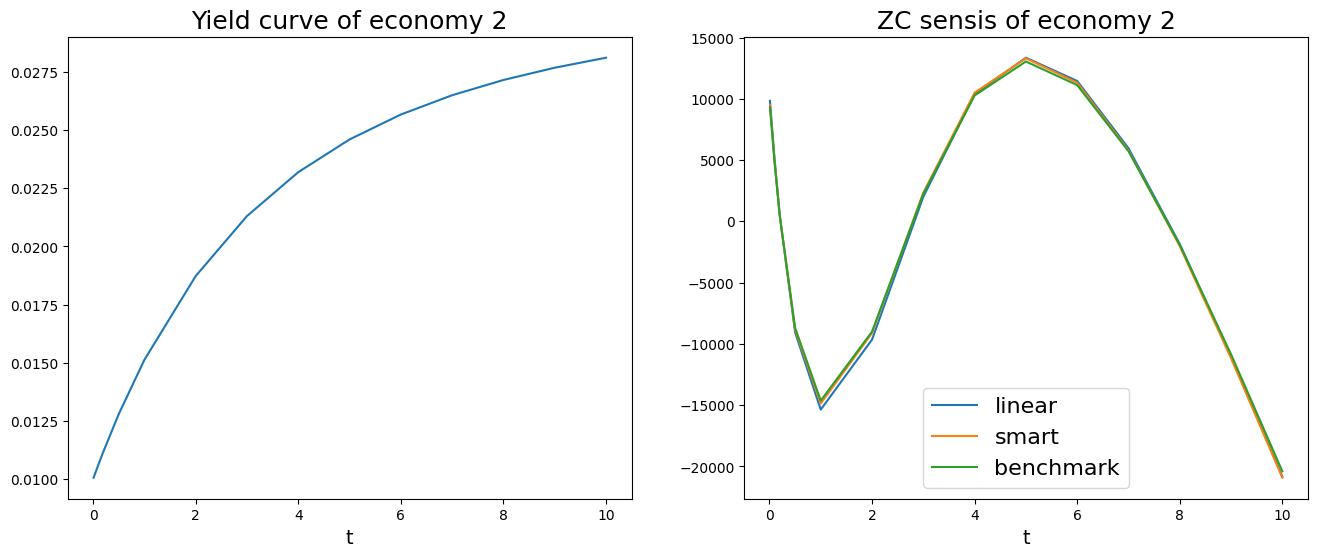

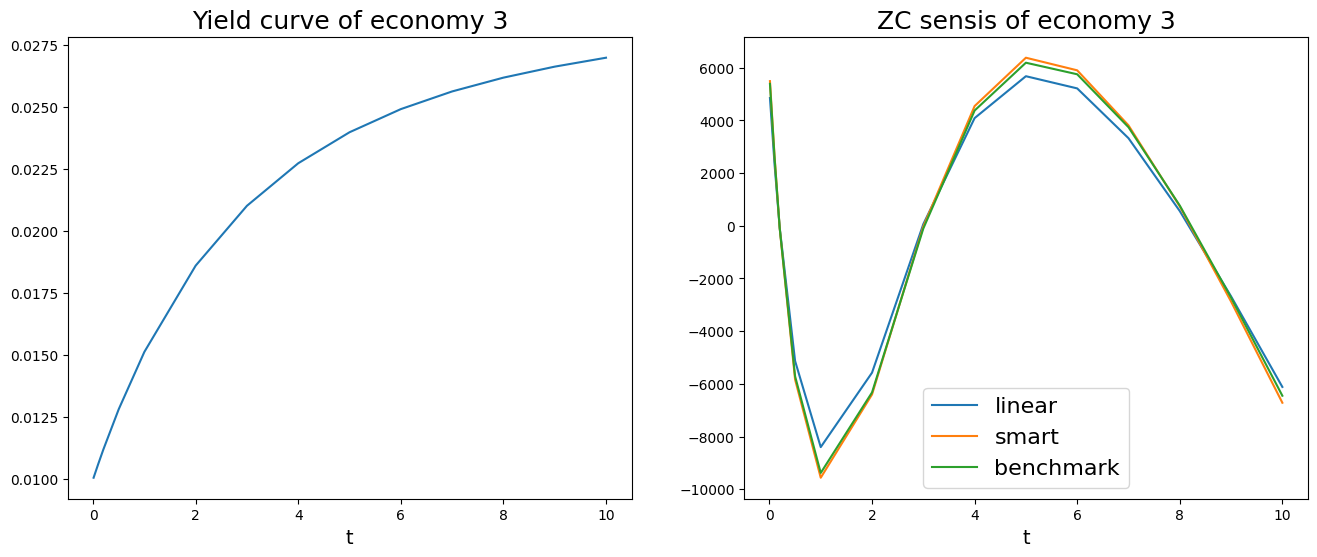

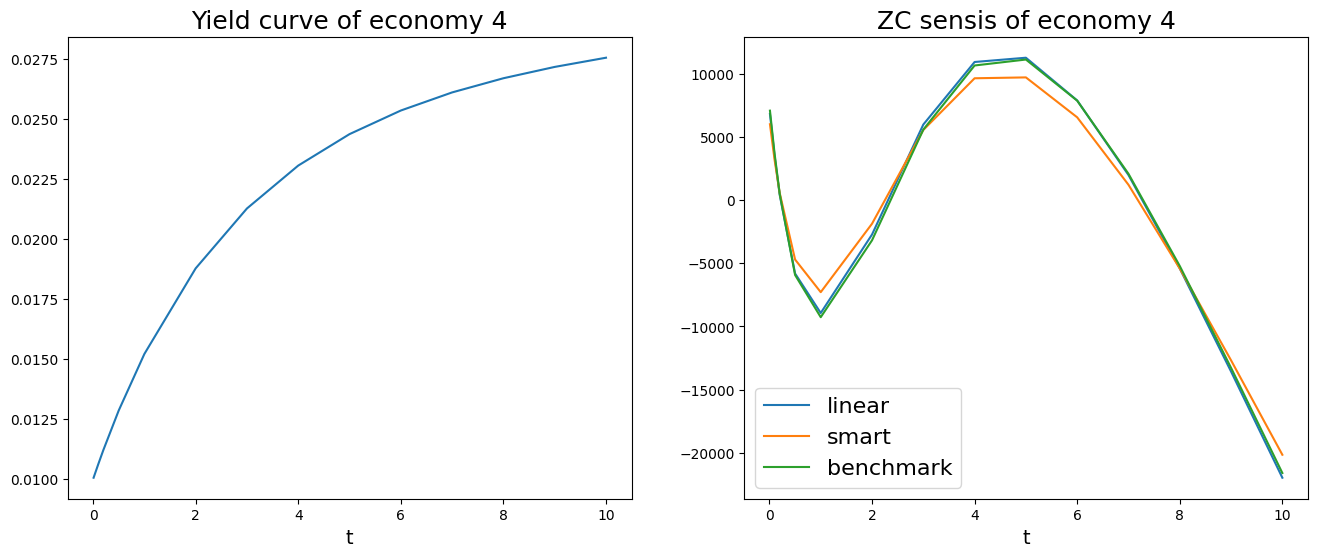

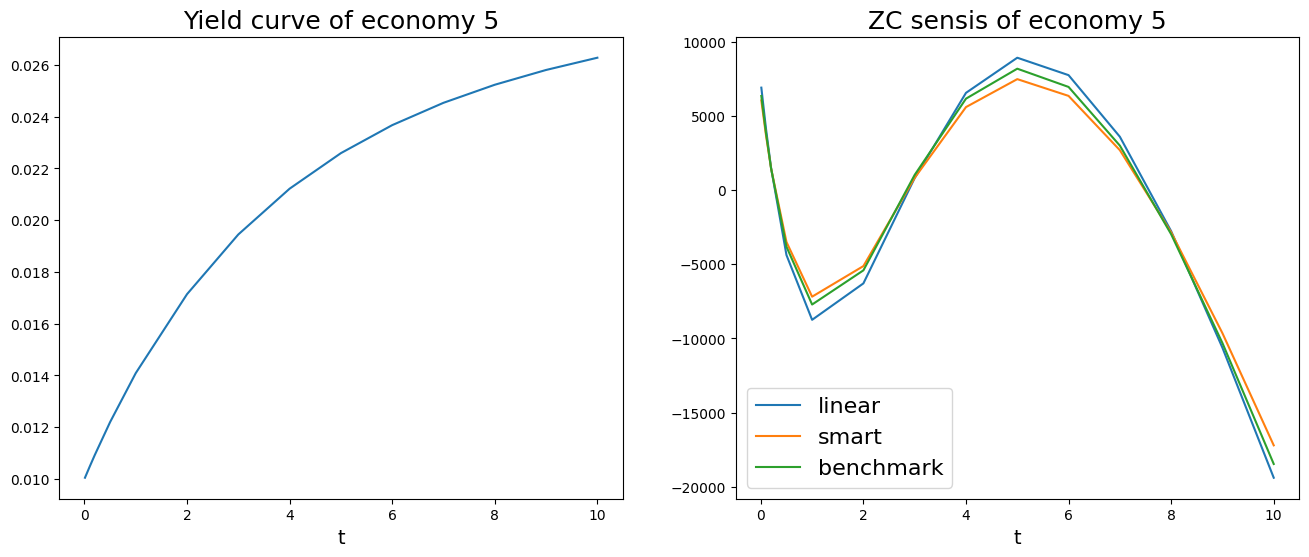

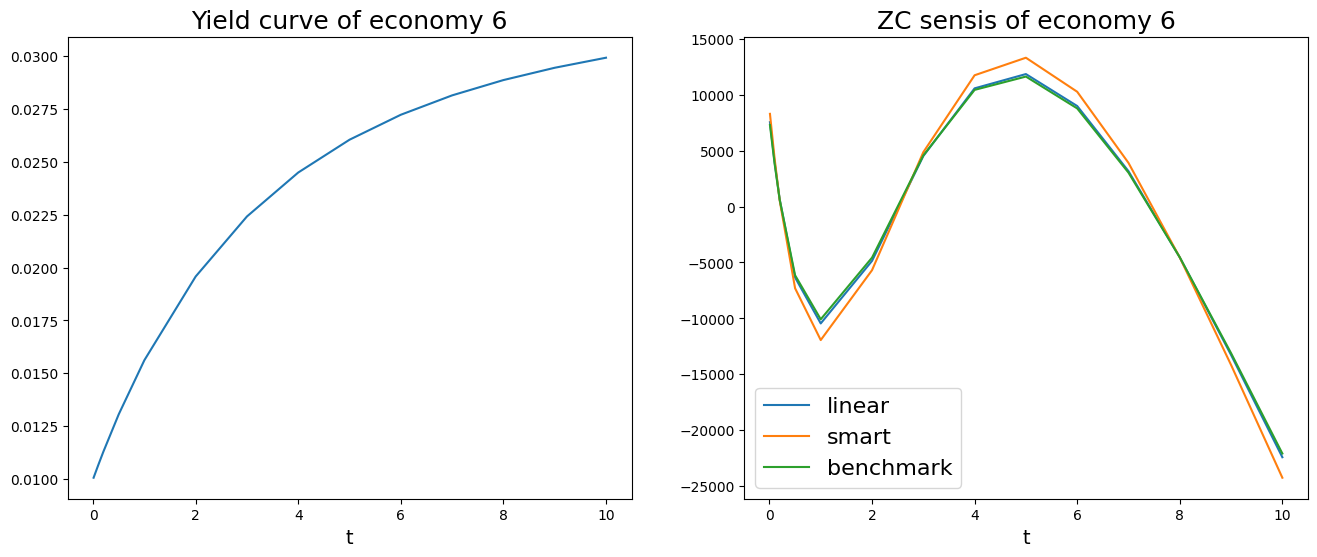

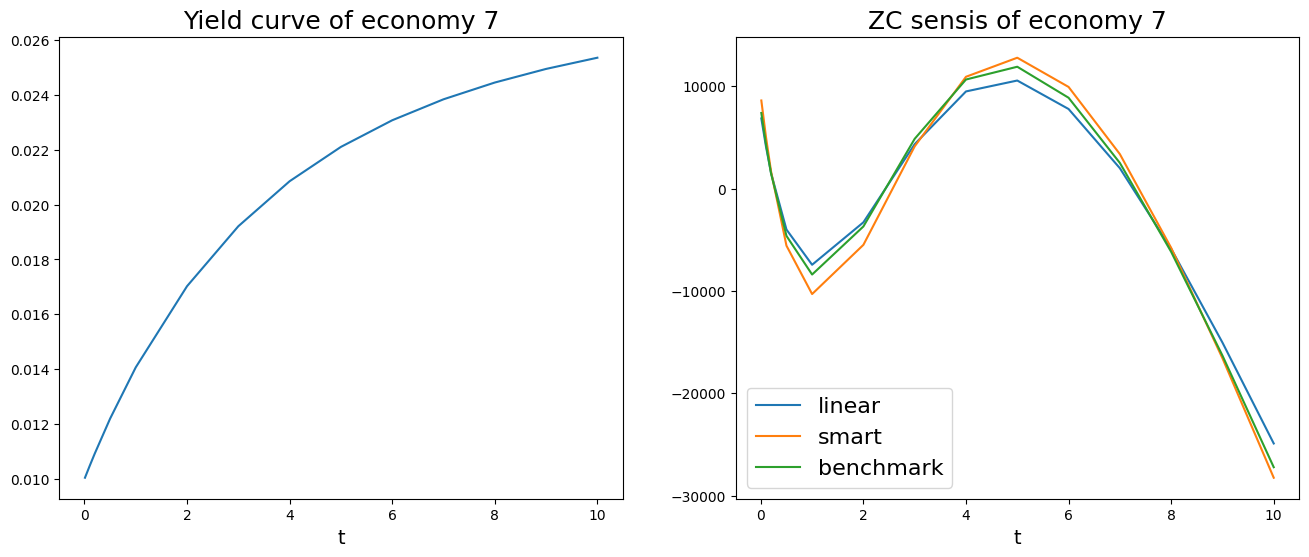

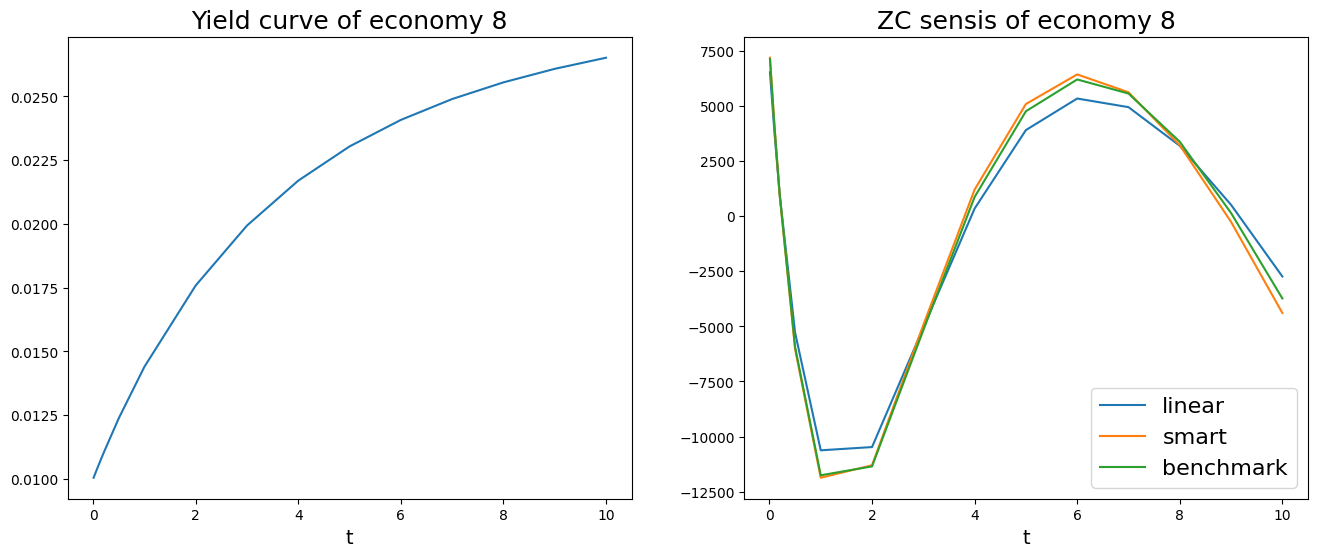

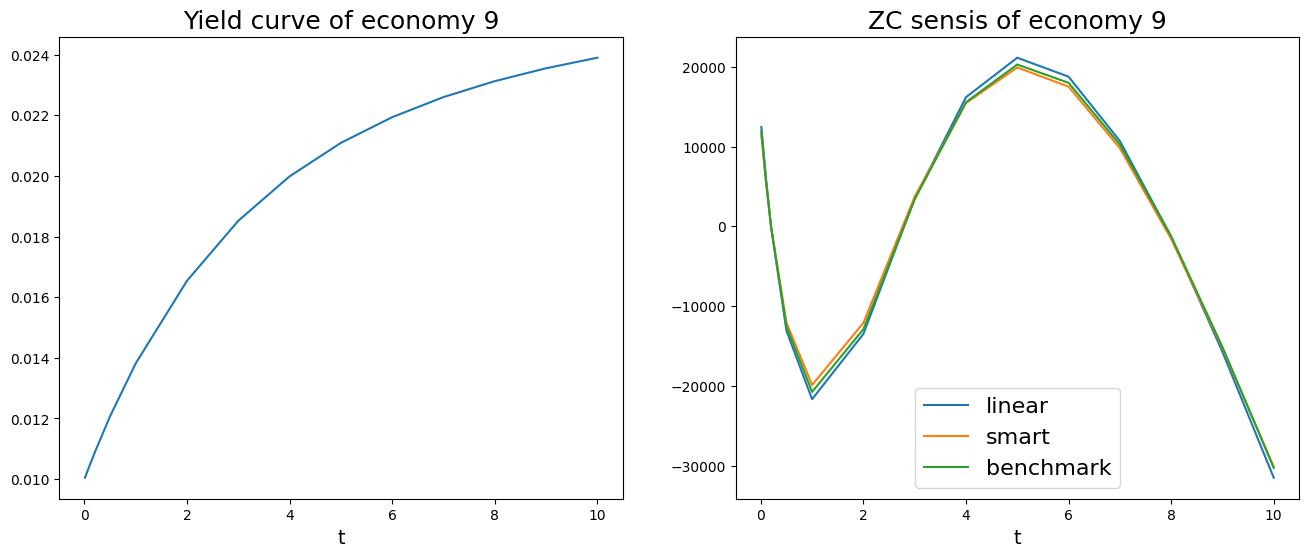

In [11]:
for edx in range(num_rates):

    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(zc_mat.cpu().numpy(),Yield_market[edx].cpu().numpy())
    #ax1.plot(zc_mat,(ZC_market))
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('Yield curve of economy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_linear[edx], label = 'linear')
    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_smart[edx], label = 'smart')
    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_benchmark[edx], label = 'benchmark')

    ax2.set_title('ZC sensis of economy ' + str(edx),fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

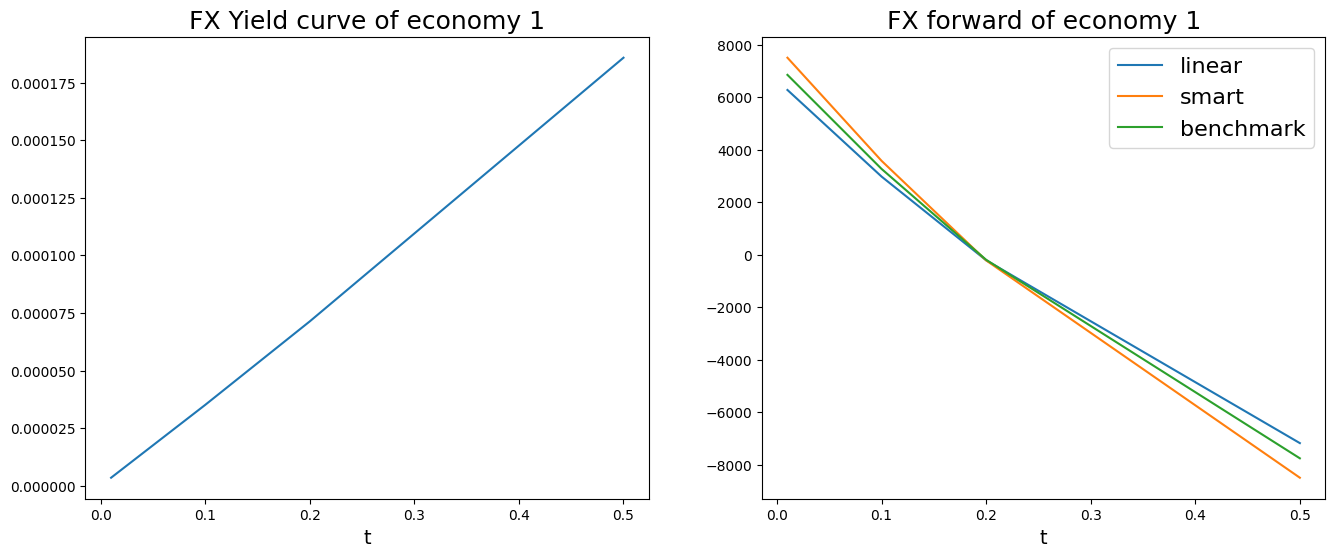

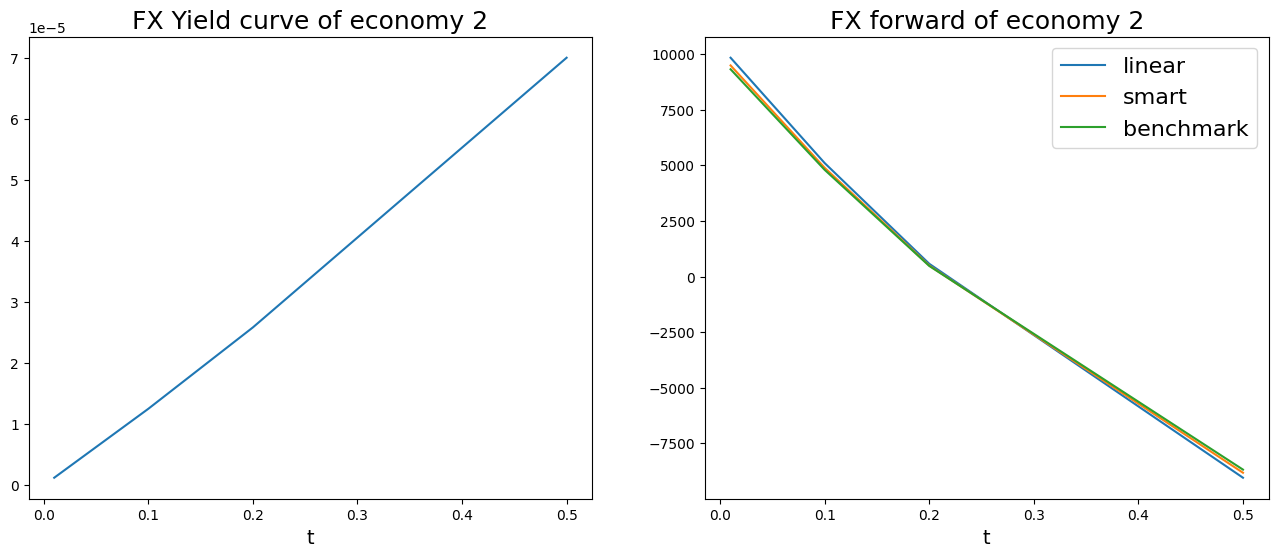

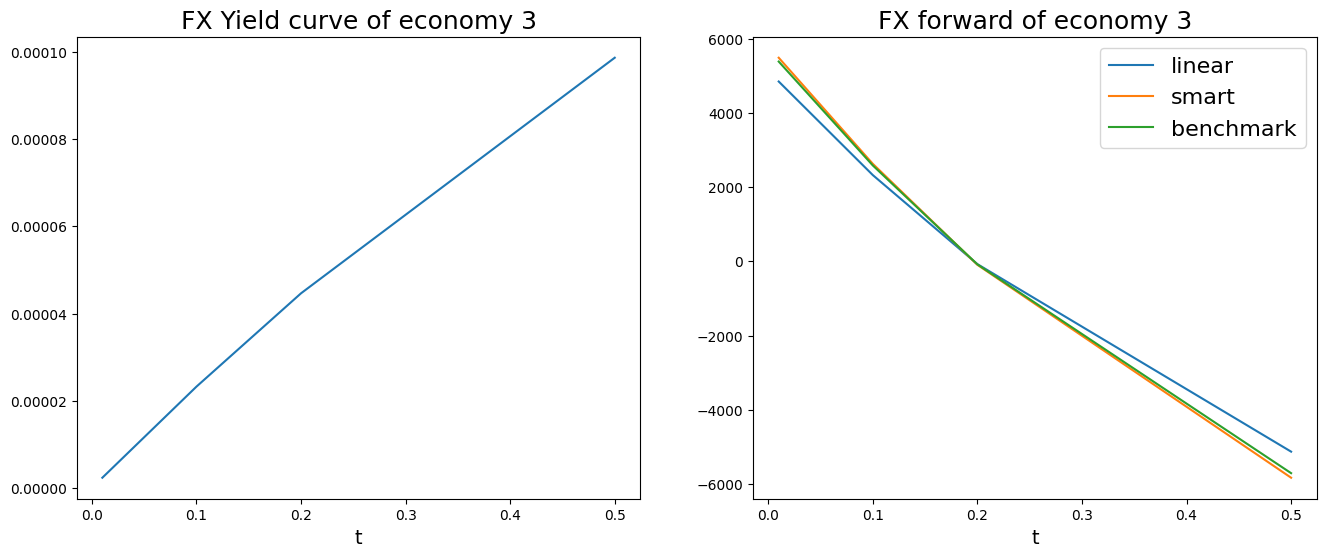

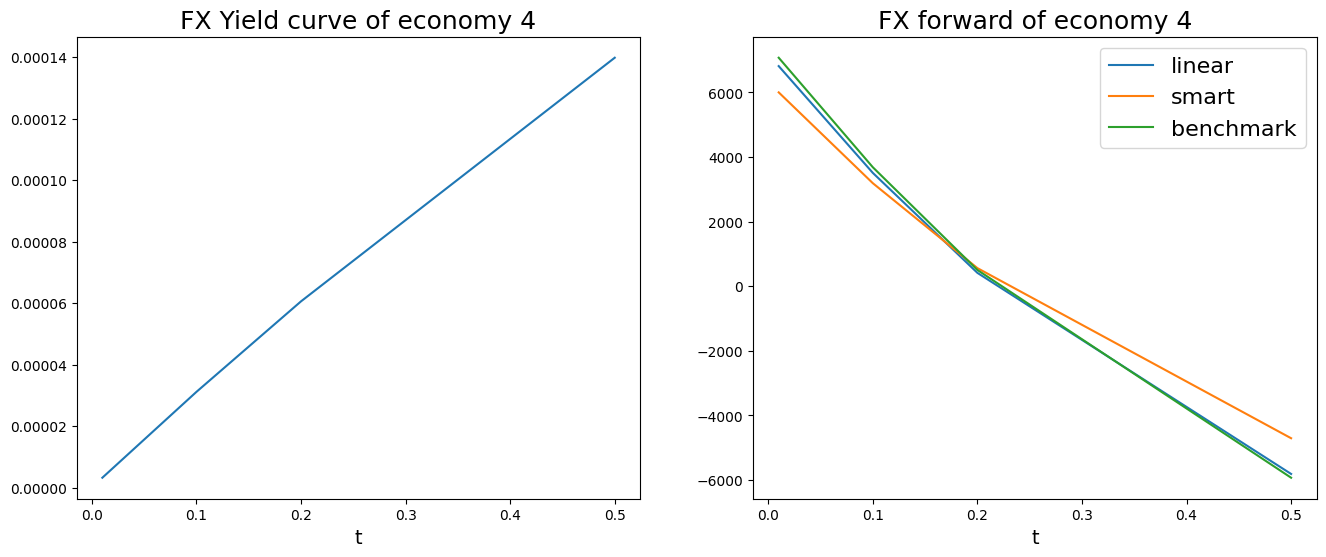

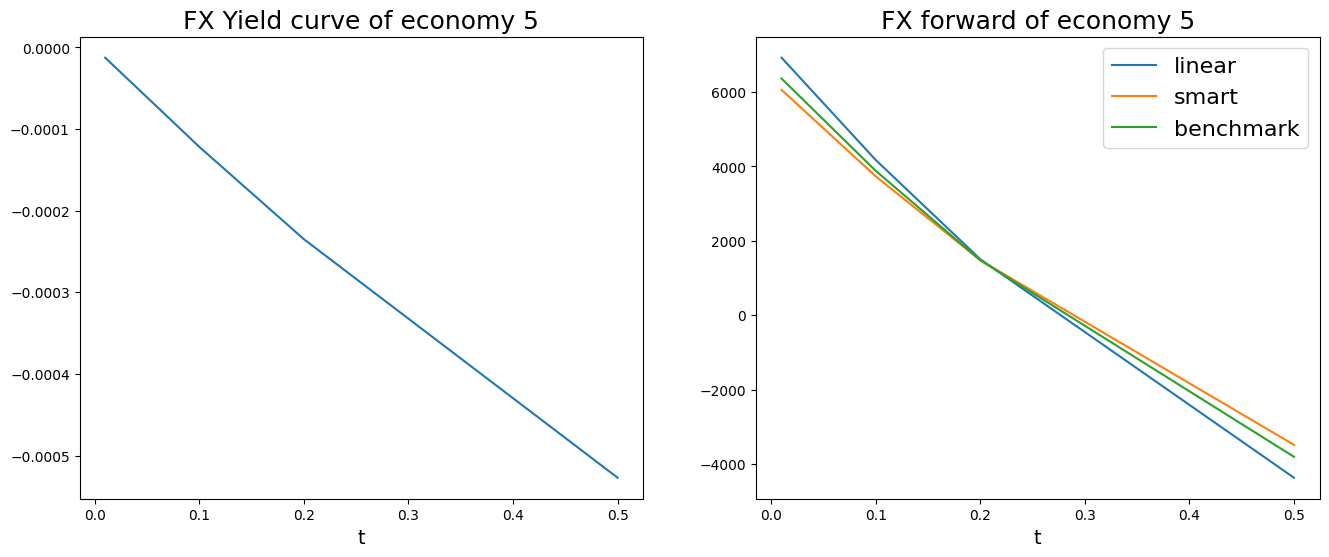

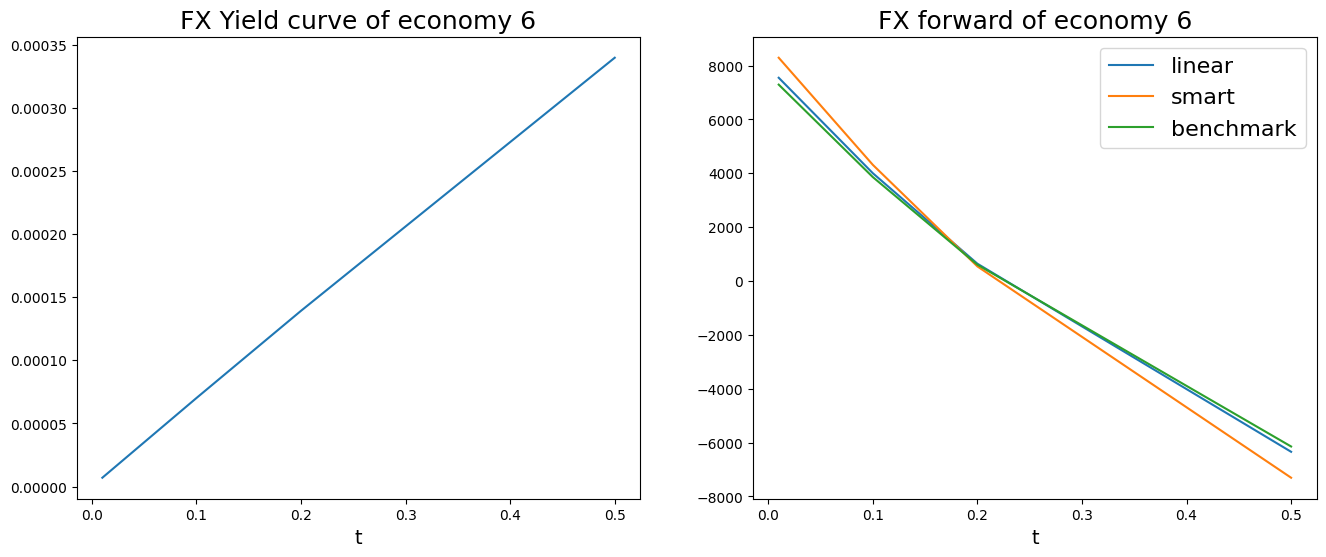

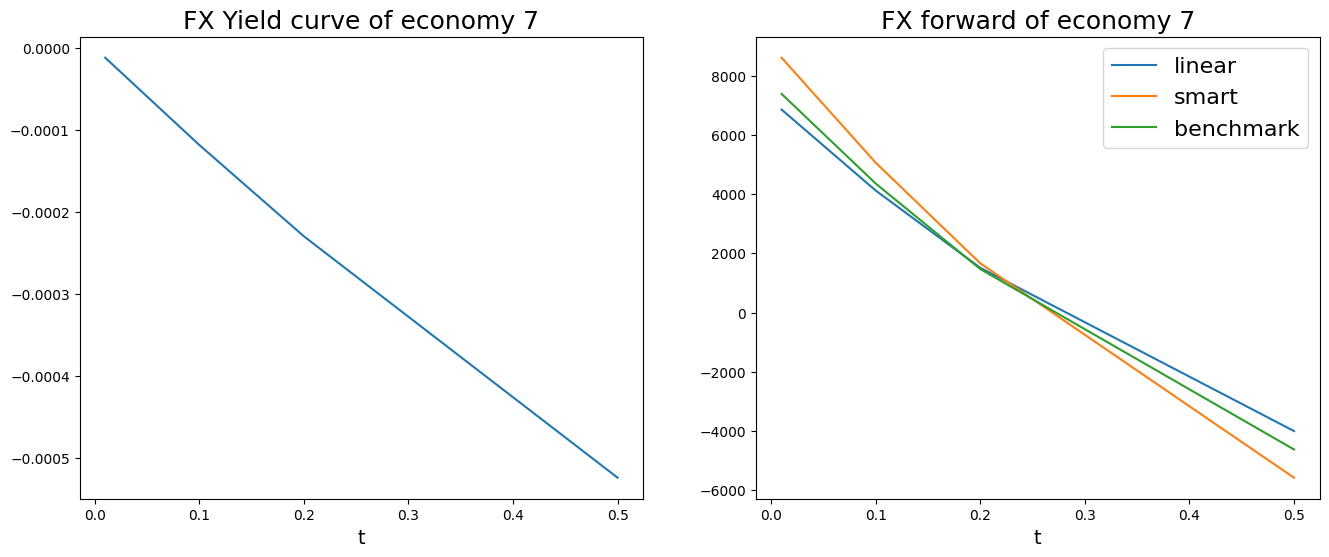

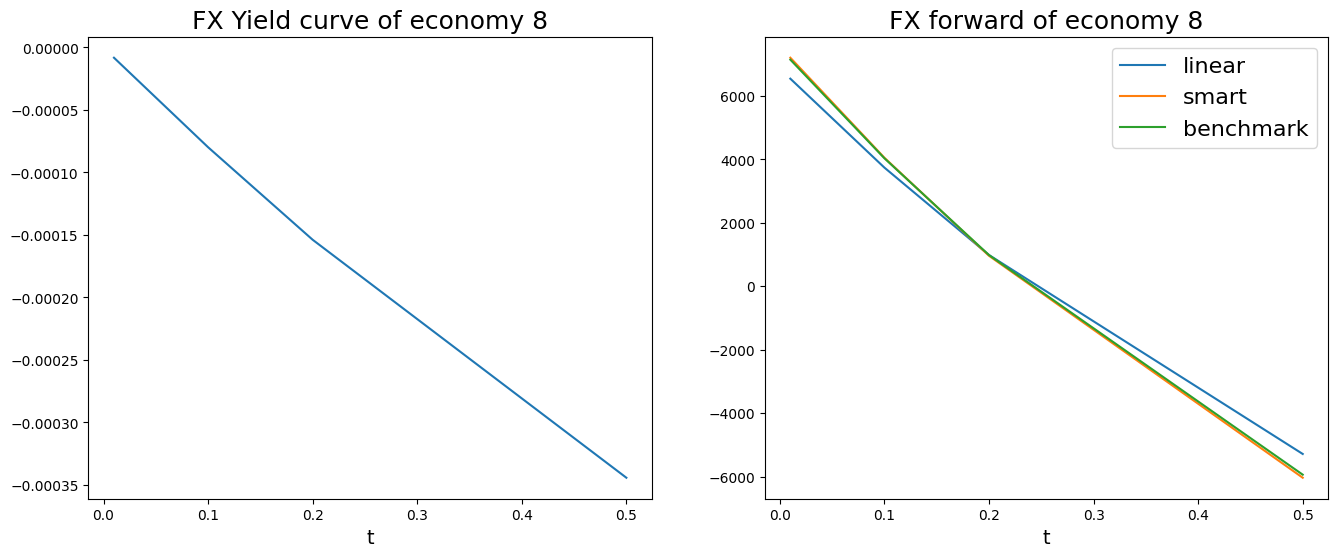

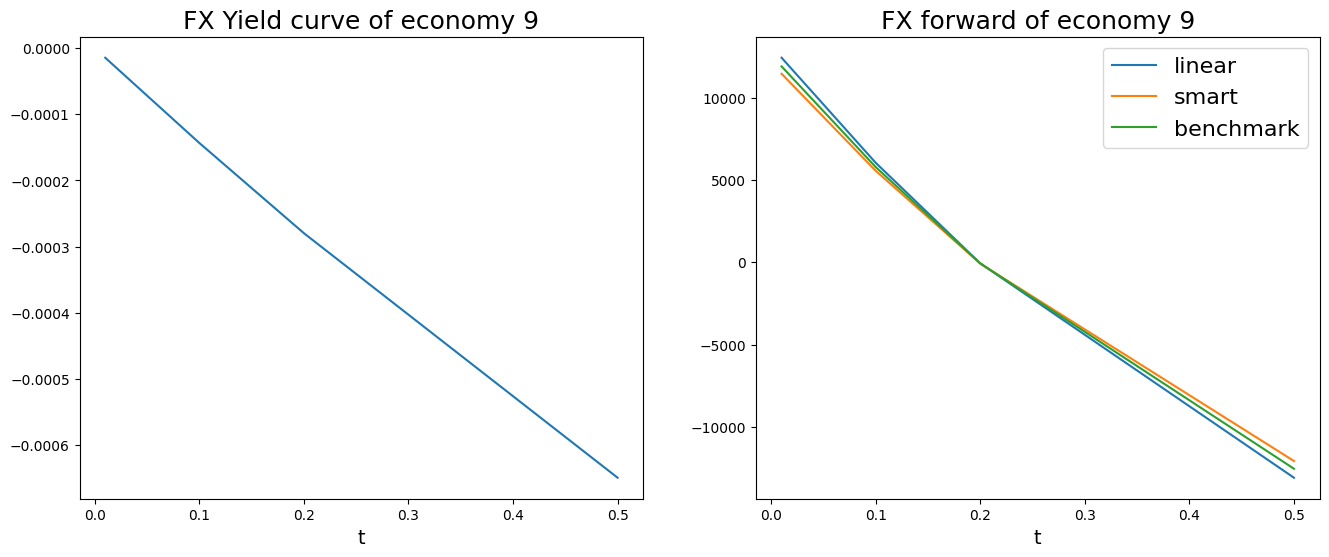

In [12]:
for edx in range(1,num_rates):

    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(zc_mat[0:4].cpu().numpy(), FX_Yield_market[edx-1][0:4].cpu().numpy() )
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('FX Yield curve of economy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_linear[edx-1][0:4], label = 'linear')
    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_smart[edx-1][0:4], label = 'smart')
    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_benchmark[edx-1][0:4], label = 'benchmark')

    ax2.set_title('FX forward of economy ' + str(edx),fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

## Sensitivities to CDS contracts

In [13]:
cds_mat = torch.tensor([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float64)
lgd_rate = 0.6
Dt = 1/10 

ini_r_ref = torch.tensor(features_origial[group[0]][0], dtype = torch.float64)
a_r_ref = torch.tensor(features_origial[group[3]][0], dtype = torch.float64)
b_r_ref = torch.tensor(features_origial[group[4]][0], dtype = torch.float64)
sig_r_ref = torch.tensor(features_origial[group[5]][0], dtype = torch.float64)

In [14]:
def A_st(a,b,vvol,s,t):
    h = torch.sqrt(a**2+2*vvol**2)
    return (2*h*torch.exp((a+h)*(t-s)/2)/(2*h+(a+h)*(torch.exp(h*(t-s))-1)))**(2*a*b/vvol**2)
def B_st(a,vvol,s,t):
    h = torch.sqrt(a**2+2*vvol**2)
    return 2*(torch.exp(h*(t-s)) - 1)/(2*h+(a+h)*(torch.exp(h*(t-s))-1))

def delta_Proba_st(g_s, a, b, vvol, s, t):

    sqrt_term = torch.sqrt(a**2 + 2 * vvol**2)
    delta_t = t - s
    exp_delta_t_sqrt = torch.exp(delta_t * sqrt_term)
    exp_2_delta_t_sqrt = torch.exp(2 * delta_t * sqrt_term)

    term1 = a**3 * b * (-1 + exp_2_delta_t_sqrt)
    term2 = 2 * a * b * (-1 + exp_2_delta_t_sqrt) * vvol**2
    term3 = a**2 * (b * (-1 + exp_delta_t_sqrt)**2 + 2 * exp_delta_t_sqrt * g_s) * sqrt_term
    term4 = 4 * exp_delta_t_sqrt * g_s * vvol**2 * sqrt_term

    AA = 2**(1 + (2 * a * b) / vvol**2) * (term1 + term2 + term3 + term4)

    term5 = torch.exp(0.5 * delta_t * (a + sqrt_term))

    term6 = (term5 * sqrt_term)
    term7 = 2 * sqrt_term + (-1 + exp_delta_t_sqrt) * (a + sqrt_term)
    BB =  term6 / term7
    BB = BB**((2 * a * b) / vvol**2)

    CC = torch.exp(-((2 * (-1 + exp_delta_t_sqrt) * g_s) / term7))

    DD = sqrt_term * (a * (-1 + exp_delta_t_sqrt) + (1 + exp_delta_t_sqrt) * sqrt_term)**2

    result = -AA * BB * CC / DD

    return result

def P_survi_st(g_s, a,b,vvol,s,t):
    return A_st(a,b,vvol,s,t) * torch.exp(-B_st(a,vvol,s,t)*g_s)

In [15]:

def CDS_spread(phi, sig_spread, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt, price = 0):
    T_list = torch.arange(float(Dt), float(T+Dt/2), float(Dt), dtype = torch.float64)
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(phi[0], phi[1], phi[2], sig_spread ,0,u )
    protection_leg = - LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64), T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(phi[0], phi[1], phi[2], sig_spread,0,u )
    
    premium_leg = torch.tensor([pricer_ZC_tT(ini_r,a_r,b_r,sig_r,0,t)*Dt*P_survi_st(phi[0], phi[1], phi[2], sig_spread, 0, t) for t in T_list], dtype = torch.float64).sum()
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64), T)
    return ( protection_leg-price)/premium_leg

def CDS_price(phi, sig_spread, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt, cds_spread):
    T_list = torch.arange(float(Dt), float(T+Dt), float(Dt), dtype = torch.float64)
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(phi[0], phi[1], phi[2], sig_spread ,0,u )
    protection_leg = - LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64), T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(phi[0], phi[1], phi[2] , sig_spread,0,u)
    
    premium_leg = torch.tensor([pricer_ZC_tT(ini_r,a_r,b_r,sig_r,0,t)*Dt*P_survi_st(phi[0], phi[1], phi[2], sig_spread, 0, t) for t in T_list], dtype = torch.float64).sum()
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64), T)
    return protection_leg - cds_spread*premium_leg



def loss_calib_CDS(cds_market, phi, sig_spread, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt, cds_spread_market):
    loss = 0.
    for mcds, ms, mat in zip(cds_market, cds_spread_market, cds_mat):
        #loss += (CDS_spread(phi, sig_spread,  a_rate, b_rate, ini_rate, sig_rate, mat, lgd, Dt, mcds ) - 
        #        ms )**2
        loss += (CDS_price(phi, sig_spread, ini_rate, a_rate, b_rate, sig_rate, mat, lgd_rate, Dt, ms ) - mcds )**2
    return loss


def jab_matrix(ini_s, a_s, b_s, sig_s, ini_rate, a_rate, b_rate, sig_rate, cds_mat, lgd_rate, Dt):

    phi = torch.tensor([ini_s, a_s, b_s], dtype = torch.float64)
    market_spread = torch.tensor([CDS_spread(phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, T, lgd_rate, Dt) for T in cds_mat], dtype = torch.float64)
    market_cds = torch.tensor([CDS_price(phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, T, lgd_rate, Dt, market_spread[i]) for i,T in enumerate(cds_mat)], dtype = torch.float64)

    hess_phi = ft_hessian(loss_calib_CDS, argnums=1)(market_cds, phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt , market_spread).to(dtype = torch.float64)    
    jac_phi_pi = jacfwd(jacfwd(loss_calib_CDS, argnums=0), argnums=1)(market_cds, phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt , market_spread).to(dtype = torch.float64)                                        

    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T


In [16]:

cds_jacobians = []

for i in range(num_spreads - 1):
    ini_s = features_origial[group[2]][i]
    a_s = features_origial[group[7]][i]
    b_s = features_origial[group[8]][i]
    sig_s = features_origial[group[9]][i]
    res = jab_matrix(ini_s, a_s, b_s, sig_s, ini_r_ref, a_r_ref, b_r_ref, sig_r_ref, cds_mat, lgd_rate, Dt)
    cds_jacobians.append(res)

/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [17]:
sensi_CDS_linear = list()
sensi_CDS_benchmark = list()
sensi_CDS_smart = list()

CDS_spread_market = list()

for edx in range(num_spreads - 1):

    ini_s = torch.tensor(features_origial[group[2]][edx], dtype = torch.float64)
    a_s = torch.tensor(features_origial[group[7]][edx], dtype = torch.float64)
    b_s = torch.tensor(features_origial[group[8]][edx], dtype = torch.float64)
    sig_s = torch.tensor(features_origial[group[9]][edx], dtype = torch.float64)

    cds_curve = torch.tensor([CDS_spread(torch.tensor([ini_s, a_s, b_s]), sig_s, ini_r_ref, a_r_ref, b_r_ref, sig_r_ref, T, lgd_rate, Dt) for T in cds_mat], dtype = torch.float64) 
    CDS_spread_market.append(cds_curve)
    tab_ini_s = tab_sensi[tab_sensi['idx'] == group[2][edx]]
    tab_a_s = tab_sensi[tab_sensi['idx'] == group[7][edx]]
    tab_b_s = tab_sensi[tab_sensi['idx'] == group[8][edx]]
    tab_sig_s = tab_sensi[tab_sensi['idx'] == group[9][edx]]

    sensi_phi_spread_linear = np.array([tab_ini_s['linear'], tab_a_s['linear'], tab_b_s['linear']], dtype = np.float32).reshape(1,3)
    sensi_phi_spread_benchmark = np.array([tab_ini_s['benchmark'], tab_a_s['benchmark'], tab_b_s['benchmark']], dtype = np.float32).reshape(1,3)
    sensi_phi_spread_smart = np.array([tab_ini_s['smart'], tab_a_s['smart'], tab_b_s['smart']], dtype = np.float32).reshape(1,3)

    sensi_CDS_linear.append(np.matmul(sensi_phi_spread_linear, cds_jacobians[edx]).ravel())
    sensi_CDS_benchmark.append(np.matmul(sensi_phi_spread_benchmark, cds_jacobians[edx]).ravel())
    sensi_CDS_smart.append(np.matmul(sensi_phi_spread_smart, cds_jacobians[edx]).ravel())
    
  
CDS_spread_market = torch.cat([cs.reshape(1,-1) for cs in CDS_spread_market])

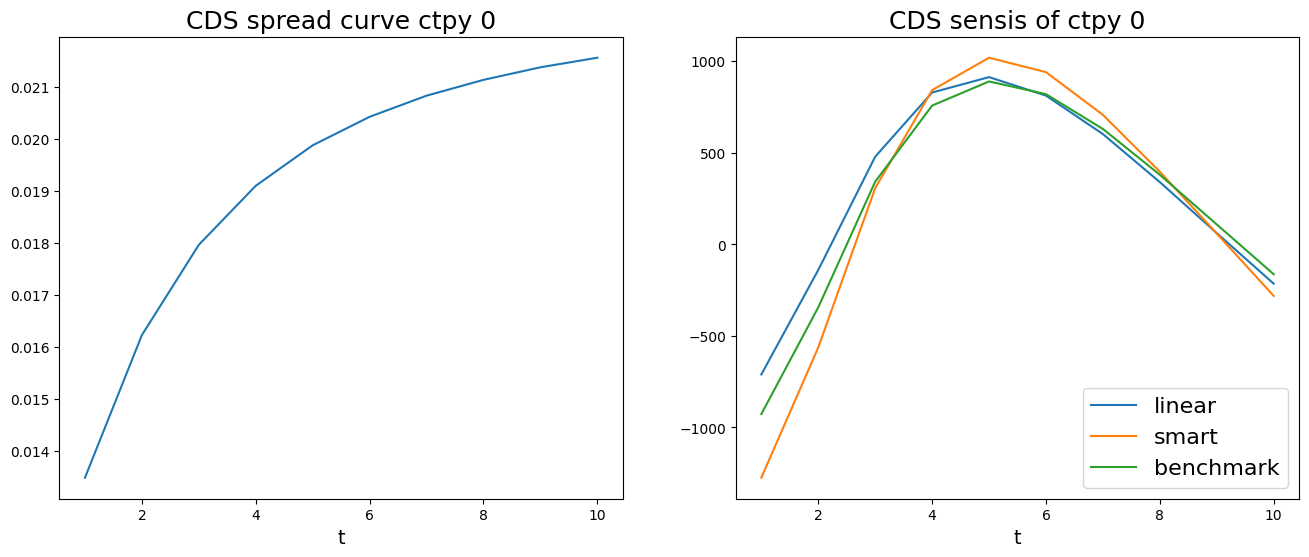

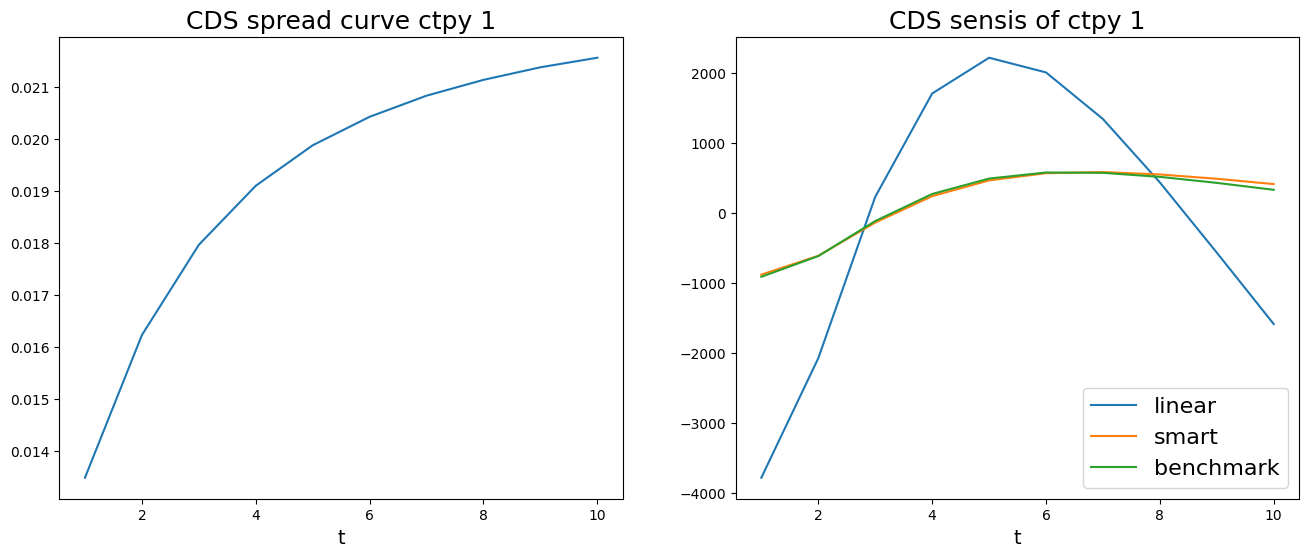

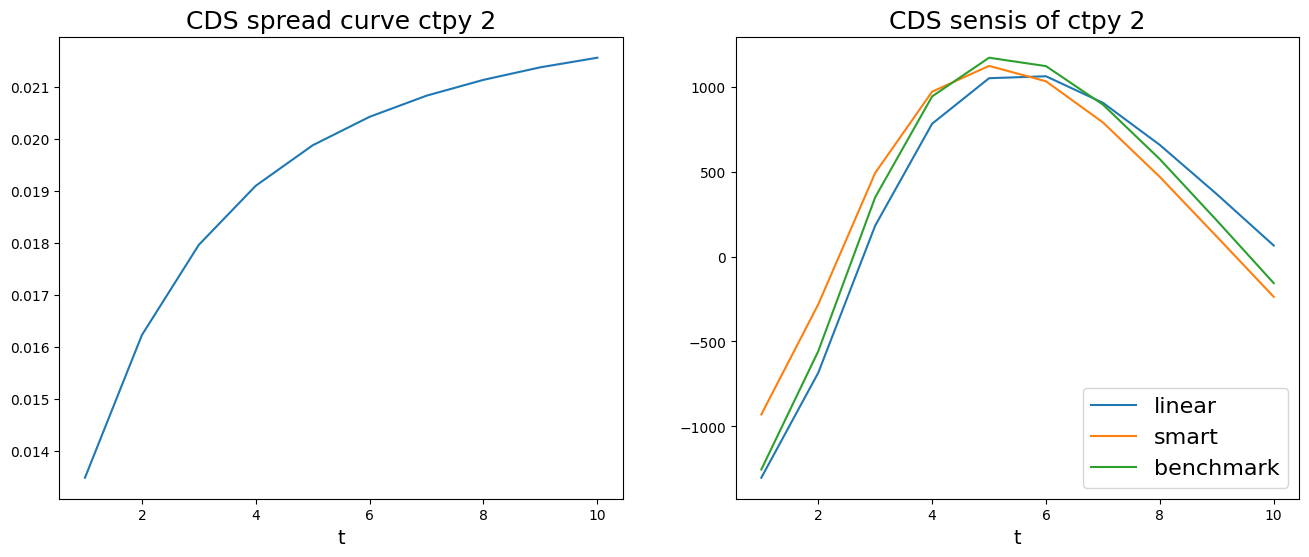

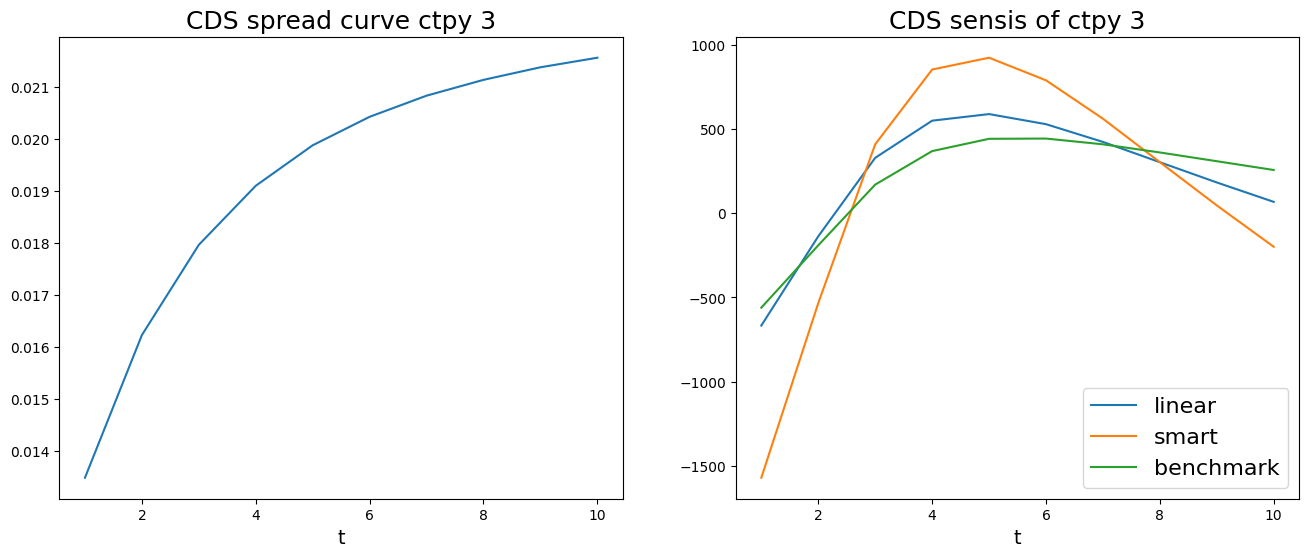

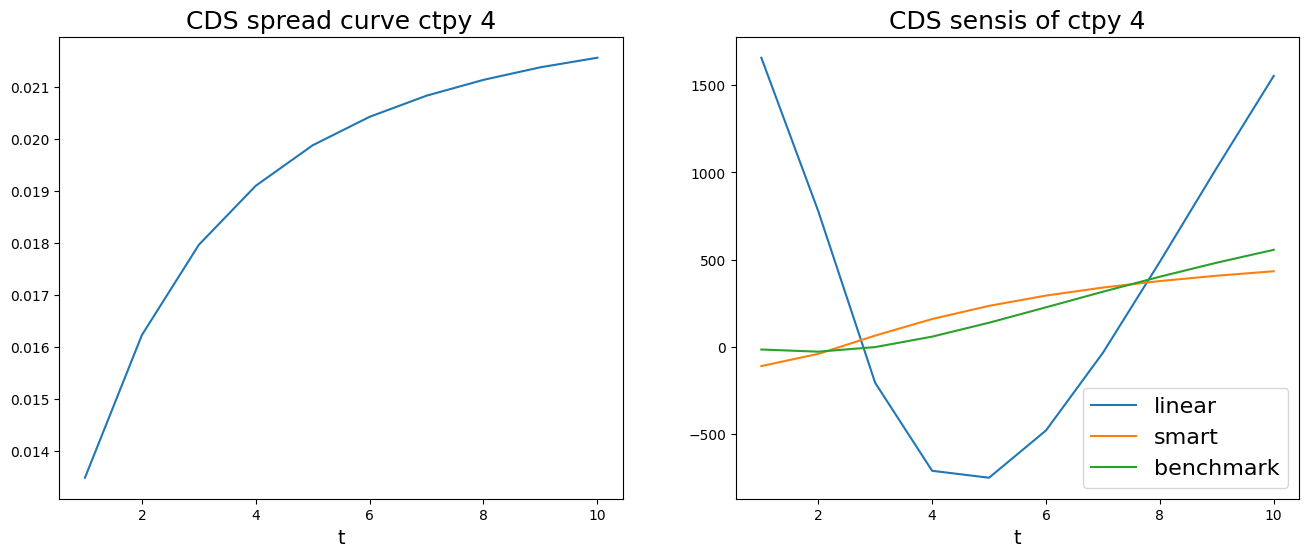

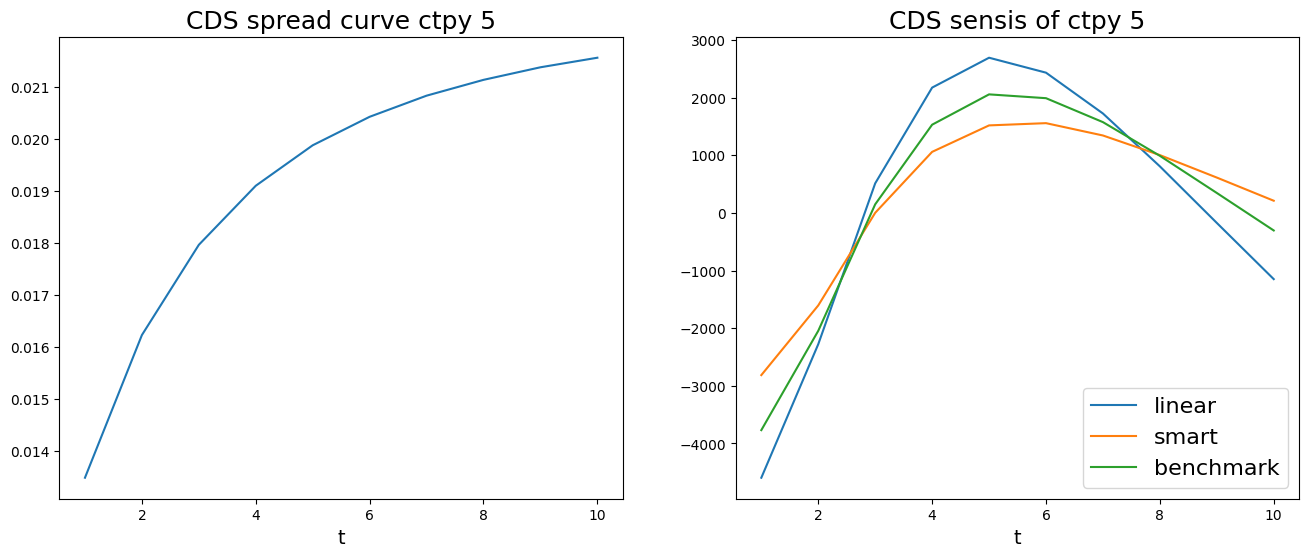

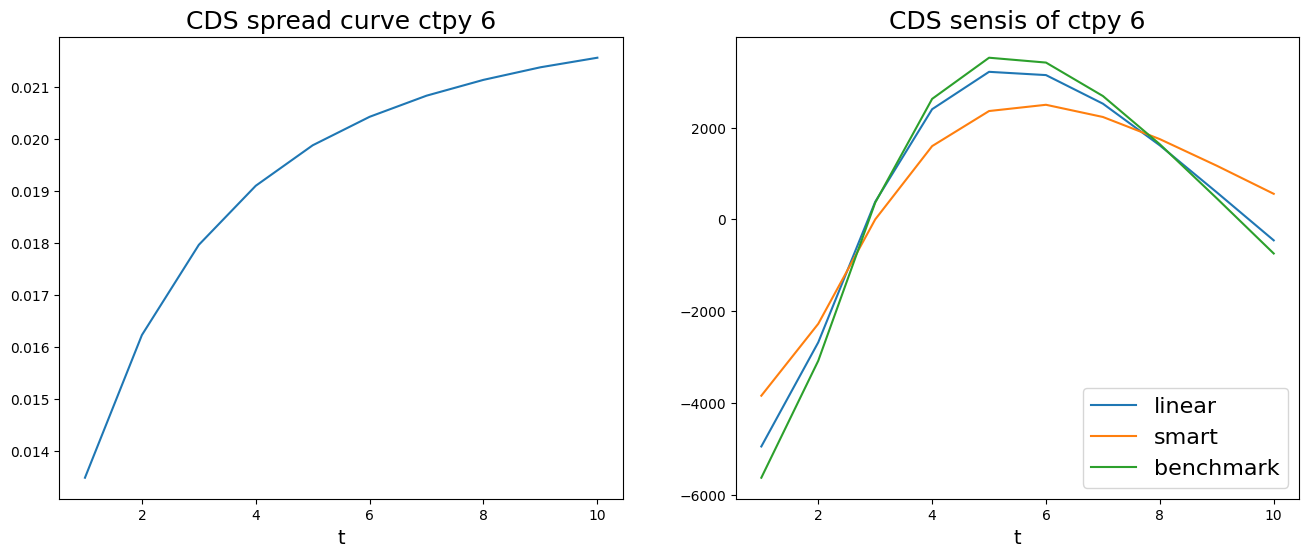

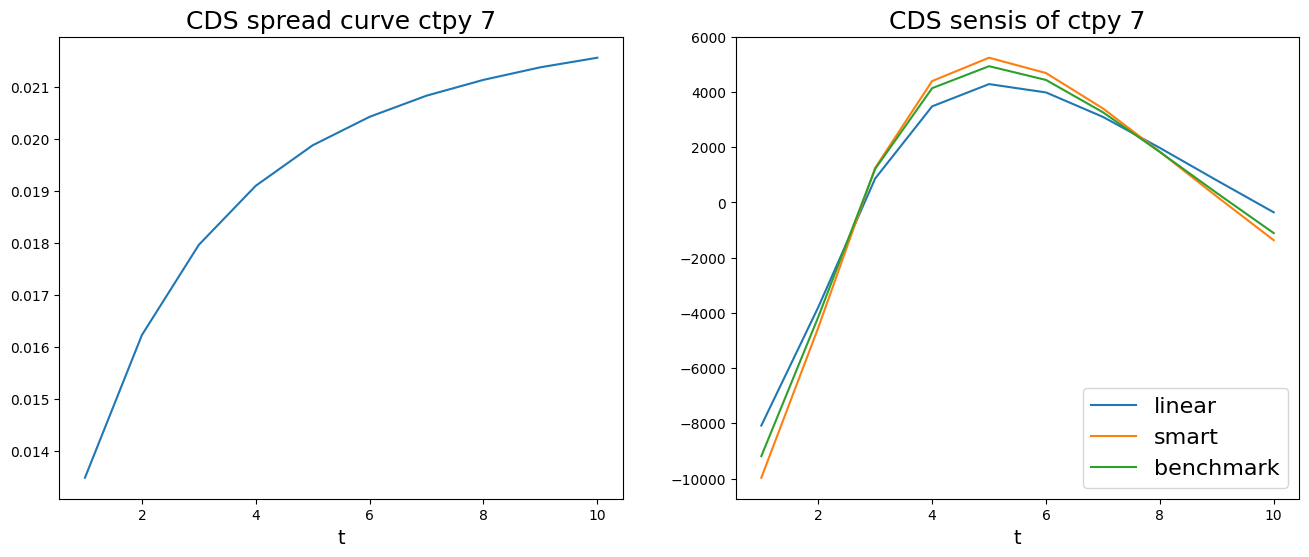

In [18]:
for edx in range(num_spreads - 1):
    
    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(cds_mat.cpu().numpy(),cds_curve.cpu().numpy())
    #ax1.plot(zc_mat,(ZC_market))
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('CDS spread curve ctpy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_linear[edx], label = 'linear')
    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_smart[edx], label = 'smart' )
    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_benchmark[edx], label = 'benchmark')

    ax2.set_title('CDS sensis of ctpy ' + str(edx) ,fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

In [19]:
sensis_market_benchmark = np.concatenate([np.array(sensi_ZC_benchmark).reshape(1,-1), 
                               np.array(sensi_FX_benchmark).reshape(1,-1),
                               np.array(sensi_CDS_benchmark).reshape(1,-1)
                               ], axis = 1)

sensis_market_smart = np.concatenate([np.array(sensi_ZC_smart).reshape(1,-1), 
                               np.array(sensi_FX_smart).reshape(1,-1),
                               np.array(sensi_CDS_smart).reshape(1,-1)
                               ], axis = 1)

sensis_market_linear = np.concatenate([np.array(sensi_ZC_linear).reshape(1,-1), 
                               np.array(sensi_FX_linear).reshape(1,-1),
                               np.array(sensi_CDS_linear).reshape(1,-1)
                               ], axis = 1)

# Computing market instruments in each simulated paths 

In [65]:
(cds_mat<=1).cpu().numpy().sum()

1

In [69]:

def CDS_price_vector(ini_s, a_s, b_s, sig_s, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt,cds_spread):
    T_list = torch.arange(Dt, max(T+Dt/2, Dt) , Dt, dtype = torch.float64)
    
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(ini_s, a_s, b_s, sig_s,0,u)
    
    protection_leg = -LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64).to(T), T).to(T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(ini_s, a_s, b_s, sig_s,0,u)
    
    premium_leg = [(pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,t)*Dt*P_survi_st(ini_s, a_s, b_s, sig_s, 0, t)).reshape(-1,1) for t in T_list]
    premium_leg = torch.cat(premium_leg,dim = 1)
    premium_leg = premium_leg.sum(dim = 1)
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64).to(T), T).to(T)
    
    return protection_leg - cds_spread*premium_leg


def market_price_calculator(paths, def_idx = None, inst_def_idx = None, cds_coupon = None, dc_pro = None, horizon = 0, horizon_idx = 0 ):
    
    ZC_market = list()
    FX_market = list()
    N = paths.shape[-2]
    
    zc_expired = (zc_mat<=horizon).cpu().numpy()
    zc_progress = (zc_mat>horizon).cpu().numpy()
    
    
    zc_mat_to_pricing_index = np.array([1, 2, 3, 6, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101])
    
    fx_strike_torch = torch.tensor(FX_strike, dtype = torch.float64).to(device)
    zc_mat_torch = torch.tensor(zc_mat, dtype = torch.float64).to(device)
    
    dc_pro_torch = torch.tensor(dc_pro, dtype = torch.float64).to(device) if dc_pro is not None else None
    
    for edx in range(num_rates):

        ini = torch.tensor(paths[-1,:,edx : edx+1], dtype = torch.float64).to(device)
        a = torch.tensor(paths[-1,:,27+edx : 27+edx+1], dtype = torch.float64).to(device)
        b = torch.tensor(paths[-1,:,37+edx : 37+edx+1], dtype = torch.float64).to(device)
        sig = torch.tensor(paths[-1,:,47+edx : 47+edx+1], dtype = torch.float64).to(device)
        fx = torch.tensor(paths[-1,:,num_rates+edx-1 : num_rates+edx], dtype = torch.float64).to(device)
        
        zc_curve = pricer_ZC_tT(ini, a,b,sig, 0, zc_mat_torch - horizon)
        if edx == 0:
            zc_ref = zc_curve.clone()
            
        else:
            
            fxt = torch.tensor(paths[zc_mat_to_pricing_index[zc_expired],:,num_rates+edx-1], dtype = torch.float64).to(device)
            fxt = fxt.T            
  
            fx_forward = zc_curve/zc_ref*fx - fx_strike_torch[edx-1].reshape(1,-1)
            fx_forward[:, zc_expired] = fxt - fx_strike_torch[edx-1][zc_expired].reshape(1,-1)        
            
            if horizon>0:
                fx_forward[:,zc_progress] *=   dc_pro_torch[-1,:]
                fx_forward[:,zc_expired] *= dc_pro_torch[zc_mat_to_pricing_index[zc_expired],:,0].T
                
                FX_market.append( (fx_forward.cpu().numpy())[:, np.newaxis, 0:4])
            else:
                FX_market.append( (fx_forward.cpu().numpy())[:, np.newaxis, 0:4])
                
            zc_curve[:,zc_progress] *= fx
            zc_curve[:,zc_expired] *= fxt
        
        if horizon>0:
            zc_curve[:,zc_progress] *=   dc_pro_torch[-1,:]
            zc_curve[:,zc_expired] *= dc_pro_torch[zc_mat_to_pricing_index[zc_expired],:,0].T
            
            ZC_market.append( (zc_curve.cpu().numpy())[:, np.newaxis, :])
        else:
            ZC_market.append( (zc_curve.cpu().numpy())[:, np.newaxis, :])
                         
    ZC_market = np.concatenate(ZC_market, axis = 1)
    FX_market = np.concatenate(FX_market, axis = 1)
    
    if horizon ==0:
        CDS_market =  np.zeros((N, num_spreads - 1, len(cds_mat)), dtype = np.float32)
    else:
        cds_mat_torch = torch.tensor(cds_mat, dtype = torch.float64).to(device)
        
        cds_spread_market_torch = torch.tensor(CDS_spread_market, dtype = torch.float64).to(device)
    
        CDS_market = list()

        ini = torch.tensor(paths[-1,:,0], dtype = torch.float64)
        a = torch.tensor(paths[-1,:,27], dtype = torch.float64)
        b = torch.tensor(paths[-1,:,37], dtype = torch.float64)
        sig = torch.tensor(paths[-1,:,47], dtype = torch.float64)


        cds_expired = (cds_mat<=horizon).cpu().numpy()
        cds_progress = (cds_mat>horizon).cpu().numpy()
        
        for edx in range(num_spreads - 1):

            ini_s = torch.tensor(paths[-1,:,19+edx], dtype = torch.float64)
            a_s = torch.tensor(paths[-1,:,66+edx], dtype = torch.float64)
            b_s = torch.tensor(paths[-1,:,74+edx], dtype = torch.float64)
            sig_s = torch.tensor(paths[-1,:,82+edx], dtype = torch.float64)

            cds_price_total = np.empty((num_paths*num_defs_per_path, 
                                        len(cds_mat)))
            
            cds_price = torch.cat([CDS_price_vector(ini_s, a_s, b_s, sig_s, ini, a, b, sig, T, lgd_rate, Dt, CDS_spread_market[edx][i] ).reshape(-1,1) 
                                   for i,T in enumerate(cds_mat[cds_progress]-horizon)], dim = 1).to(device)
            if cds_expired.any():
                cds_price = torch.cat([torch.zeros((len(cds_price), cds_expired.sum())).to(cds_price), 
                                       cds_price], dim = 1)
            cds_price *= dc_pro_torch[-1,:]
            
            def_idx_torch =torch.empty((num_paths , 1), dtype = torch.float64).to(device)
            inst_def_idx_torch = torch.empty((num_paths , horizon_idx), dtype = torch.float64).to(device)
            cds_coupon_torch = torch.empty((num_paths , horizon_idx), dtype = torch.float64).to(device)
            
            for j in range(num_defs_per_path):
                def_idx_torch.copy_( torch.tensor(def_idx[horizon_idx][j*num_paths: (j+1)*num_paths, edx: edx+1], dtype = torch.float64))
                inst_def_idx_torch.copy_( torch.tensor(inst_def_idx[1:horizon_idx+1, j*num_paths: (j+1)*num_paths, edx].T, dtype = torch.float64))
                cds_coupon_torch.copy_( torch.tensor(cds_coupon[1:horizon_idx+1, j*num_paths: (j+1)*num_paths, edx].T, dtype = torch.float64))
                
                c = (cds_price * (1- def_idx_torch)  
                    + lgd_rate*torch.sum(inst_def_idx_torch * dc_pro_torch[1:horizon_idx+1, :, 0].T, dim = 1, keepdim =True)
                    - torch.sum( cds_coupon_torch
                                    * dc_pro_torch[1:horizon_idx+1, :, 0].T, dim = 1, keepdim=True) * cds_spread_market_torch[edx].reshape(1,-1) 
                     ) 
                cds_price_total[j*num_paths: (j+1)*num_paths] = c.cpu().numpy()
                
            CDS_market.append( cds_price_total[:,np.newaxis, : ])

        CDS_market = np.concatenate(CDS_market, axis = 1)

    try:
        del cds_price, def_idx_torch, inst_def_idx_torch, cds_coupon_torch, fx_strike_torch, dc_pro_torch, cds_spread_market_torch, zc_mat_torch, cds_mat_torch
    except:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    
    return np.concatenate([ZC_market.reshape(N,-1),
                       FX_market.reshape(N,-1),
                       CDS_market.reshape(N,-1)
                      ], axis = 1)

We define CDS coupons, which are paid at the end of each month if the CDS contract has not expired or expires at that moment. If the CDS contract expires at t=0.01, 1/10 of the coupon will be paid.

In [70]:

def_ind_train = [d.cumsum(axis = 0) for d in instant_def_ind_train]
def_ind_test = [d.cumsum(axis = 0) for d in instant_def_ind_test]

cds_coupon_train = [i.copy() for i in def_ind_train]
cds_coupon_test = [i.copy() for i in def_ind_test]


for i in range(len(cds_coupon_train)):
    for j in range(1,len(cds_coupon_train[i])):
       
        cds_coupon_train[i][j] = 1 - cds_coupon_train[i][j]
        cds_coupon_test[i][j] = 1 - cds_coupon_test[i][j]
    cds_coupon_train[i] += instant_def_ind_train[i]
    cds_coupon_test[i] += instant_def_ind_test[i]
    
for i in range(1,len(cds_coupon_train)):
    cds_coupon_train[i][1] =  (cds_coupon_train[i][1] != cds_coupon_train[i][2])*0.1
    cds_coupon_test[i][1] =  (cds_coupon_test[i][1] != cds_coupon_test[i][2])*0.1
    
cds_coupon_train[0][1] *= 0.1
cds_coupon_test[0][1] *= 0.1

In [71]:

features_market0 = market_price_calculator(features_baseline0[np.newaxis], None, None, None, None, horizon = 0, horizon_idx = 0)

features_market_train = np.empty((3, features_train[0].shape[1], features_market0.shape[1]))

features_market_test = np.empty((3, features_test[0].shape[1], features_market0.shape[1]))

for i, (risk_horizon, risk_horizon_idx) in tqdm(enumerate(zip([0.01, 0.1,1], [1,2,11]))):

    features_market_train[i,:,:] = market_price_calculator(features_train[i], def_ind_train[i], 
                                instant_def_ind_train[i], cds_coupon_train[i], dc_factor_train[i], risk_horizon, risk_horizon_idx)
    features_market_test[i,:,:] = market_price_calculator(features_test[i], def_ind_test[i], 
                                instant_def_ind_test[i], cds_coupon_test[i], dc_factor_test[i], risk_horizon, risk_horizon_idx)
    


/tmp/ipykernel_3015593/3828003640.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fx_strike_torch = torch.tensor(FX_strike, dtype = torch.float64).to(device)
/tmp/ipykernel_3015593/3828003640.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zc_mat_torch = torch.tensor(zc_mat, dtype = torch.float64).to(device)
0it [00:00, ?it/s]/tmp/ipykernel_3015593/3828003640.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cds_mat_torch = torch.tensor(cds_mat, dtype = torch.float64).to(device)
/tmp/ipykernel_3015593/3828003640.py:84: UserWa

Compute delta market risk factors

In [72]:
d_features_market_train = features_market_train -features_market0[np.newaxis]
d_features_market_test = features_market_test -features_market0[np.newaxis]

# Run-off CVA risk

In [ ]:
from tool import ES_Regression, poly_square, hedging_error_standardized, pl_explain,twin_score, var_score, es_score

In [73]:
def tile(x, rep = num_defs_per_path):
    return np.tile(x.T, rep).T

In [74]:
d_CVA_test = np.concatenate([(CVA_nn_test[i]*tile(dc_factor_test[i][-1]))[np.newaxis] for i in range(3)], axis = 0) - CVA_0

d_CVA_LGD_train = np.concatenate([(CVA_nn_train[i]*tile(dc_factor_train[i][-1]) + LGD_train[i])[np.newaxis] for i in range(3)], axis = 0) - CVA_0
d_CVA_LGD_test = np.concatenate([(CVA_nn_test[i]*tile(dc_factor_test[i][-1]) + LGD_test[i])[np.newaxis] for i in range(3)], axis = 0) - CVA_0

In [90]:
def es_score(m, q =0.95):
    the = np.quantile(m,q)
    return m[m>=the].mean()
res_risk_sensi = pd.DataFrame(columns=['metrics', 'score_type', 'score', 'time'])
for i, t in enumerate([0.01,0.1,1]):
    for nh, er in zip([
                       r'$\beta_t*CVA_t-CVA_0$',
                      r'$\beta_t*LGD_t$', r'$\beta_t*(CVA_t+LGD_t)-CVA_0$'], [ 
                                                    d_CVA_test[i], LGD_test[i], d_CVA_LGD_test[i]]):
        new_row = {'time': t,'metrics': nh, 'score_type': '0_mean', 
                                           'score': er.mean()}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '1_var95',
                                           'score': var_score(er,q = 0.95)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '2_var975',
                                           'score': var_score(er,q = 0.975)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '3_var99',
                                           'score': var_score(er,q = 0.99)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '4_es95',
                                           'score': es_score(er,q = 0.95)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '5_es975',
                                           'score': es_score(er,q = 0.975)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row

        new_row = {'time': t,'metrics': nh, 'score_type': '5_es99',
                                           'score': es_score(er,q = 0.99)}
        res_risk_sensi.loc[len(res_risk_sensi)] = new_row
        '''
        new_row = {'timestep': ts, 'hedge_type': nh, 'score_type': '2_es95', 
                                           'score': es_score(er[i],q = 0.95)}
        m_vares_res_mixture.loc[len(m_vares_res_mixture)] = new_row

        new_row = {'timestep': ts, 'hedge_type': nh, 'score_type': '3_es975', 
                                           'score': es_score(er[i],q = 0.975)}
        m_vares_res_mixture.loc[len(m_vares_res_mixture)] = new_row
        '''

In [91]:
res_risk_sensi.pivot(columns='metrics', index = ['time', 'score_type'], values = 'score').iloc[:,[1,2,0]]#.to_csv('a.csv')

metrics          $\beta_t*CVA_t-CVA_0$  $\beta_t*LGD_t$  \
time score_type                                           
0.01 0_mean                 -20.762859         0.255614   
     1_var95                669.070850         0.000000   
     2_var975               819.834277         0.000000   
     3_var99                996.166475         0.000000   
     4_es95                 872.560242         0.255614   
     5_es975               1007.463013         0.255614   
     5_es99                1173.948364         0.255614   
0.10 0_mean                  43.991852         7.799157   
     1_var95               1138.268408         0.000000   
     2_var975              1365.024255         0.000000   
     3_var99               1651.724219         0.000000   
     4_es95                1453.191772         7.799157   
     5_es975               1663.622803         7.799157   
     5_es99                1922.913574         7.799157   
1.00 0_mean                 549.880615       493.689270   
     1_var95               3874.971582      3561.613025   
     2_var975              4795.131274      7143.326965   
     3_var99               5958.685879     11684.508086   
     4_es95                5193.167969      8661.105469   
     5_es975               6108.972656     12141.055664   
     5_es99                7352.889160     16674.638672   

metrics          $\beta_t*(CVA_t+LGD_t)-CVA_0$  
time score_type                                 
0.01 0_mean                         -20.507244  
     1_var95                        669.664038  
     2_var975                       820.708105  
     3_var99                        998.174565  
     4_es95                         875.100220  
     5_es975                       1012.052856  
     5_es99                        1184.150513  
0.10 0_mean                          51.791000  
     1_var95                       1158.906201  
     2_var975                      1397.817615  
     3_var99                       1707.445752  
     4_es95                        1521.098511  
     5_es975                       1776.820557  
     5_es99                        2143.813232  
1.00 0_mean                        1043.569946  
     1_var95                       5664.953418  
     2_var975                      8508.101880  
     3_var99                      13239.480273  
     4_es95                       10331.375000  
     5_es975                      13832.541992  
     5_es99                       18812.216797

/tmp/ipykernel_3015593/2413581169.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  id_alpha_opt = int(np.where(percs==95)[0])
/tmp/ipykernel_3015593/2413581169.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  id_alpha_opt2 = int(np.where(percs==97.5)[0])
/tmp/ipykernel_3015593/2413581169.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  id_alpha_opt3 = int(np.where(percs==99)[0])


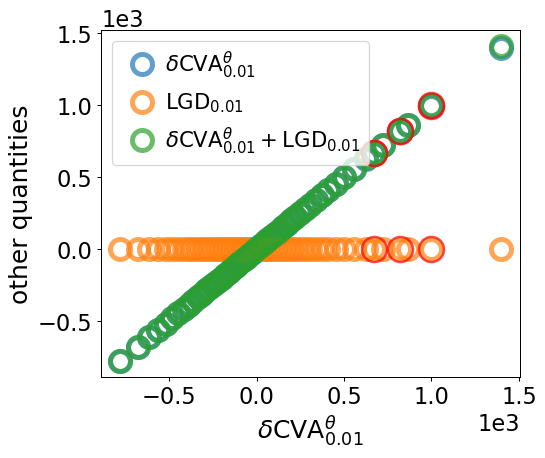

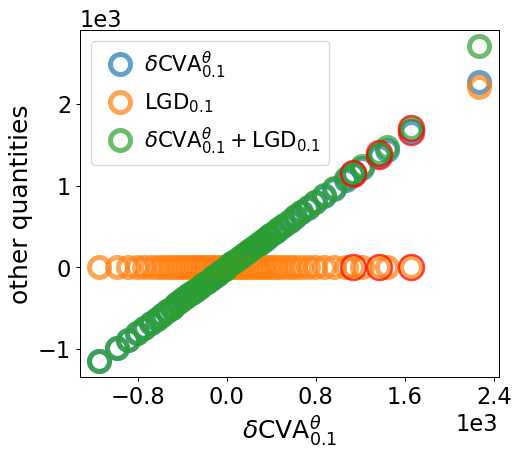

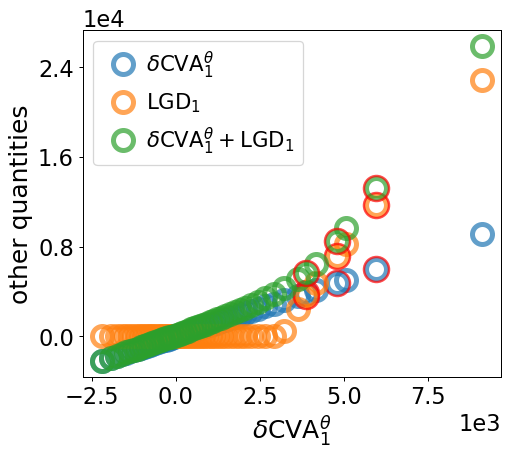

In [75]:

for time_indx, t  in enumerate([0.01,0.1,1]): 
    fig, (ax) = plt.subplots(1,1,figsize=(6,5), dpi = 90, facecolor='white')
    color = ['C0', 'C1', 'C2', 'C4', 'C5', 'C8', 'C9']
    percs = np.array(list(np.linspace(0,100,51,)[1:-1])+ [97.5, 99.9, 95, 99])
    percs.sort()
    id_alpha = 0
    id_alpha_opt = int(np.where(percs==95)[0])
    id_alpha_opt2 = int(np.where(percs==97.5)[0])
    id_alpha_opt3 = int(np.where(percs==99)[0])

    qn_ref = np.percentile(d_CVA_test[time_indx], percs)
    qn_sample = [np.percentile(s, percs) for s in [  d_CVA_test[time_indx], 
        LGD_test[time_indx], d_CVA_LGD_test[time_indx]]]
    name_h = [  r'$\delta \mathrm{CVA}^\theta_{{%s}}$'%t,
                      r'$\mathrm{LGD}_{{%s}}$'%t, r'$\delta \mathrm{CVA}^\theta_{{%s}}'%t+r'+\mathrm{LGD}_{{%s}}$' %t]

    for i in range(len(qn_sample)):
        ax.plot(qn_ref[id_alpha:],qn_sample[i][id_alpha:], markersize = 16 ,
                marker="o", alpha =  0.7, label = name_h[i], markerfacecolor="none",
               markeredgecolor = color[i], markeredgewidth = 4, ls = "")

        ax.plot(qn_ref[id_alpha_opt],qn_sample[i][id_alpha_opt], ls="", markersize = 20,
                marker="o", alpha =  0.7, markerfacecolor="none", 
                markeredgecolor = 'red', markeredgewidth = 2)

        ax.plot(qn_ref[id_alpha_opt2],qn_sample[i][id_alpha_opt2], ls="", markersize = 20,
                marker="o", alpha =  0.7, markerfacecolor="none", 
                markeredgecolor = 'red', markeredgewidth = 2)

        ax.plot(qn_ref[id_alpha_opt3],qn_sample[i][id_alpha_opt3], ls="", markersize = 20,
                marker="o", alpha =  0.7, markerfacecolor="none", 
                markeredgecolor = 'red', markeredgewidth = 2)


    ax.set_xlabel(r'$\delta \mathrm{CVA}^\theta_{{%s}}$'%t, fontsize = 20)   
    ax.set_ylabel('other quantities', fontsize = 20)  
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.yaxis.get_offset_text().set_fontsize(18)
    ax.xaxis.get_offset_text().set_fontsize(18)
    ax.xaxis.set_major_locator(MaxNLocator(nbins = 5,integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(nbins = 5,integer=True))
    ax.legend(loc='upper left', frameon=True, fontsize = 17,handletextpad=0.1, columnspacing=0.1)
    plt.show()     


# Run-off CVA hedging

In [77]:
def hedging_error(model, X, d_cva):
    model.intercept_ = 0    
    pred = model.predict(X).reshape(-1,1)
    c = d_cva.reshape(-1,1).mean() - pred.mean()

    return d_cva - pred -c, c



In [78]:
model_market_benchmark = LinearRegression(fit_intercept=False)
model_market_smart = LinearRegression(fit_intercept=False)
model_market_linear = LinearRegression(fit_intercept=False)

model_market_benchmark.coef_ = sensis_market_benchmark.reshape(1,-1)
model_market_smart.coef_ = sensis_market_smart.reshape(1,-1)
model_market_linear.coef_ = sensis_market_linear.reshape(1,-1)
model_market_benchmark.intercept_ = 0
model_market_smart.intercept_ = 0
model_market_linear.intercept_ = 0


model_market_PLE = Ridge(fit_intercept=True, alpha = 1e-3)

model_market_EC = ES_Regression(device = device, alpha = 0.95, lr = 0.005, num_batch= 1,  
                                       epochs=8000, fit_intercept=True, weight_decay= 1e-3)


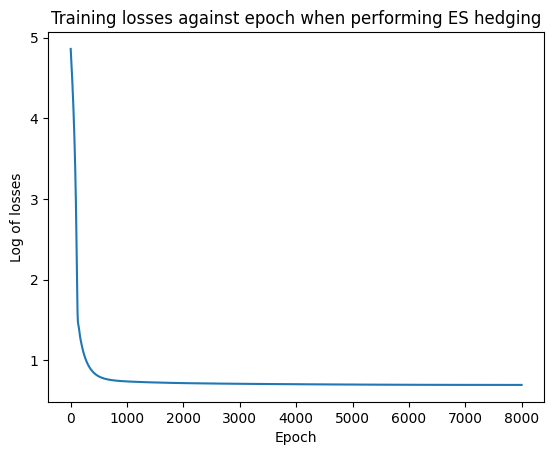

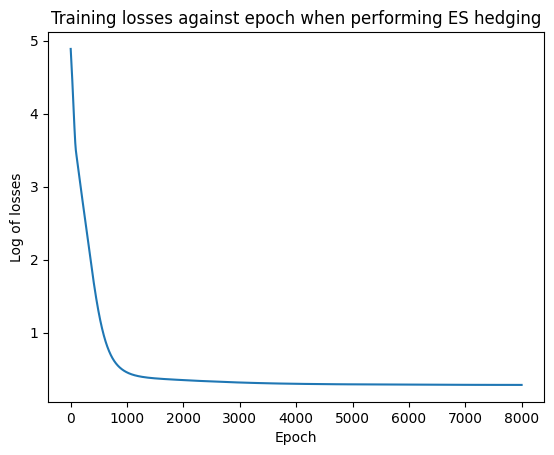

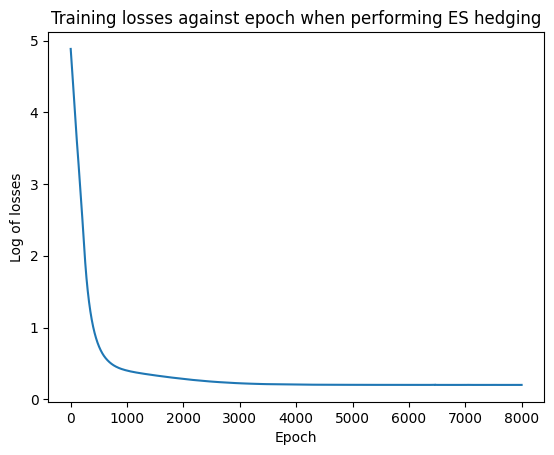

In [79]:
name_hedge = ['0_unhedge', '1_benchmark_bump',  '2_smart_bump', '3_linear_bump', 
              '4_EC', '5_PLE']

err_unhedge = []
err_hedge_benchmark =[]
err_hedge_smart =[]
err_hedge_linear =[]

err_hedge_EC =[]
err_hedge_PLE =[]


for i,_ in enumerate(risk_horizons):
   
    model_market_PLE.fit(d_features_market_train[i], d_CVA_LGD_train[i])
    
    model_market_EC.fit(d_features_market_train[i], d_CVA_LGD_train[i])

    err_unhedge.append((d_CVA_LGD_test[i], d_CVA_LGD_test[i].mean()))
    err_hedge_benchmark.append(hedging_error(model_market_benchmark, d_features_market_test[i], d_CVA_LGD_test[i]))
    err_hedge_smart.append(hedging_error(model_market_smart, d_features_market_test[i], d_CVA_LGD_test[i]))
    err_hedge_linear.append(hedging_error(model_market_linear, d_features_market_test[i], d_CVA_LGD_test[i]))
    
    err_hedge_EC.append(hedging_error(model_market_EC, d_features_market_test[i], d_CVA_LGD_test[i]))
    err_hedge_PLE.append(hedging_error(model_market_PLE, d_features_market_test[i], d_CVA_LGD_test[i]))
    

In [80]:
CVA_hedging_run_off = pd.DataFrame(columns=['risk_horizon', 'hedge_type', 'score_type', 'score'])
for i,ts in enumerate(risk_horizons):

    for hedge_name, err_hedge in zip(name_hedge, [err_unhedge, err_hedge_benchmark, err_hedge_smart, 
                                  err_hedge_linear, err_hedge_EC, err_hedge_PLE]):
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '0_mean', 
                                           'score': float(err_hedge[i][0].mean())}
        CVA_hedging_run_off.loc[len(CVA_hedging_run_off)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '1_std_compress_ratio', 
                                           'score': float(err_unhedge[i][0].std()/err_hedge[i][0].std())}
        CVA_hedging_run_off.loc[len(CVA_hedging_run_off)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '2_es_compress_ratio',
                   'score': float(es_score(err_unhedge[i][0], 0.95)/ es_score(err_hedge[i][0], 0.95))}
        CVA_hedging_run_off.loc[len(CVA_hedging_run_off)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '3_c',
                   'score': float(err_hedge[i][1])}
        CVA_hedging_run_off.loc[len(CVA_hedging_run_off)] = new_row
        

In [81]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(CVA_hedging_run_off.pivot_table(values = 'score', index = 'risk_horizon', columns=['score_type', 'hedge_type']).round(4))

score_type       0_mean                                                   \
hedge_type    0_unhedge 1_benchmark_bump 2_smart_bump 3_linear_bump 4_EC   
risk_horizon                                                               
0.01           -20.5072              0.0          0.0           0.0  0.0   
0.10            51.7910              0.0          0.0           0.0  0.0   
1.00          1043.5699             -0.0         -0.0          -0.0 -0.0   

score_type         1_std_compress_ratio                                \
hedge_type   5_PLE            0_unhedge 1_benchmark_bump 2_smart_bump   
risk_horizon                                                            
0.01           0.0                  1.0           1.0880       1.0855   
0.10           0.0                  1.0           0.0912       0.0886   
1.00          -0.0                  1.0           0.1004       0.0971   

score_type                                 2_es_compress_ratio  \
hedge_type   3_linear_bump    4_EC   5

/tmp/ipykernel_3015593/1113718854.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[j].axhline(y = (float(res[(res['hedge_type'] =='0_unhedge') & (res['risk_horizon'] ==t) & (res['score_type'] ==score)]['score'])),  linestyle  = '-.', c = c_list[i], lw = 3)


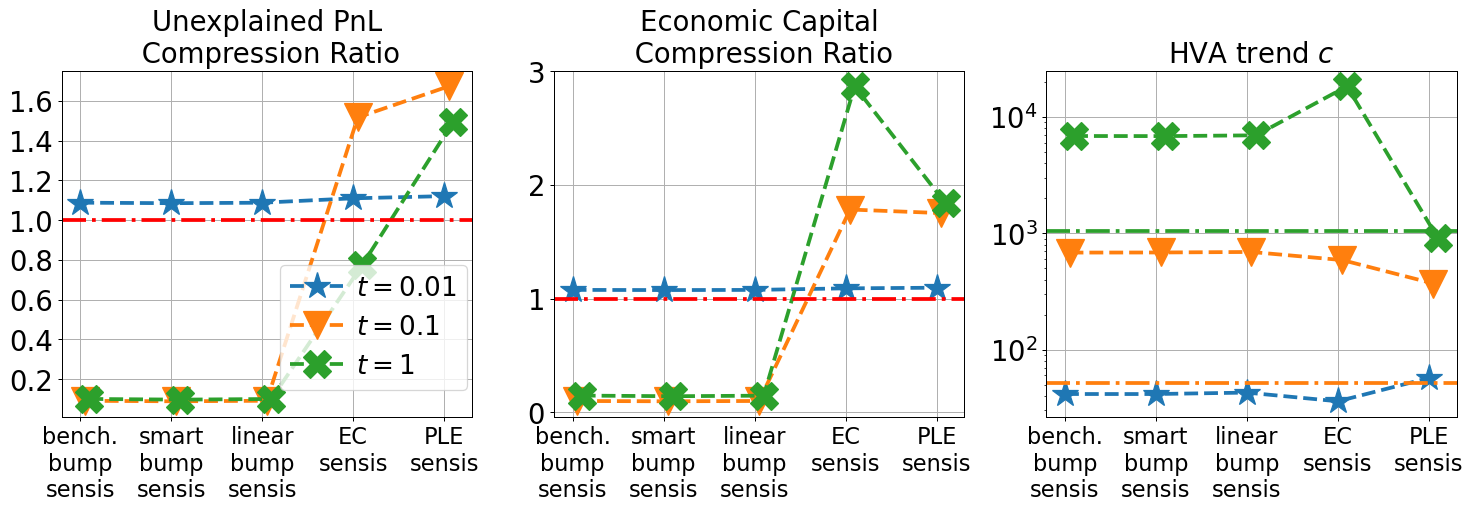

In [87]:
from matplotlib.ticker import LogLocator, LogFormatter


m_list = ['*', 'v', 'X', 'o', 'D', 's']
c_list = ['C0','C1','C2']*2

fig, ax = plt.subplots(1,3,figsize=(20,5),  dpi = 90)
plt.subplots_adjust(wspace=0.2)

res = CVA_hedging_run_off
for j, (name_s, score) in enumerate(zip(["Unexplained PnL\n Compression Ratio", 'Economic Capital\n Compression Ratio', 'HVA trend $c$'], 
                                        ['1_std_compress_ratio', '2_es_compress_ratio', '3_c'])):

    i = 0
    res_delta =  res[res['hedge_type'].isin(['1_benchmark_bump',  '2_smart_bump', '3_linear_bump',
                                             '4_EC', '5_PLE'])]
    
    for itt, t in enumerate([0.01,0.1,1]):

        res_sub_delta = res_delta.loc[(res_delta['risk_horizon']==t) & (res_delta['score_type']==score)]

        iddd = np.arange(len(res_sub_delta['hedge_type']))
        ax[j].plot(iddd+itt*0.05#res_sub_delta['hedge_type']
                , res_sub_delta['score'],  
                 linestyle  = '--', 
                 marker = m_list[i], c = c_list[i],
                markersize =22, label = "$t= $"+str(t), linewidth  = 3)
        ax[j].set_xticks(iddd, res_sub_delta['hedge_type'])  
        

        if j == 2:
            ax[j].axhline(y = (float(res[(res['hedge_type'] =='0_unhedge') & (res['risk_horizon'] ==t) & (res['score_type'] ==score)]['score'])),  linestyle  = '-.', c = c_list[i], lw = 3)
        i+=1
    if j<2:
        ax[j].axhline(y = 1,  linestyle  = '-.', c = 'red', lw = 3)
    xtick_name = ['bench.\nbump\nsensis', 'smart\nbump\nsensis', 'linear\nbump\nsensis',
                  'EC\nsensis', 'PLE\nsensis' ] #if j == 0 else ['point. \n bump sensis', 'fast bump \n sensis', 'one-shot \n LS sensis', 'LS \n sensis', 'EC \n sensis']
    #if score == '2_es':
    #    xtick_name = ['No hedge']+ xtick_name
    ax[j].set_xlabel('', fontsize = 1)  
    ax[j].set_xticklabels(xtick_name#, rotation = 45
               #res_delta['hedge_type'].unique(),
                       )  
    ax[j].set_title(name_s, fontsize = 22)  
    ax[j].xaxis.set_tick_params(labelsize=18)
    ax[j].yaxis.set_tick_params(labelsize=22)
    ax[j].grid()
    if j <2:
        ax[j].yaxis.set_major_locator(MaxNLocator(nbins = 10,integer=True))
    else:
        ax[j].set_yscale('log', base=10, )


legd = plt.legend( loc='lower center', bbox_to_anchor=(-1.64, 0.04),
fancybox=True, fontsize = 21, frameon=True, ncol=1,handletextpad=0.5, columnspacing=0.5)
#plt.savefig('sensi.pdf', #bbox_extra_artists=(legd,), 
#        bbox_inches='tight')

plt.show()
